<div style="background-color: #faf0e6; border: 2px solid #ccc; padding: 8px; text-align: center;">
    <h1 style="color: #696969; margin: 8px 0;">Traffic Vehicle Real Time Detection - ML Notebook 2 of 2</h1>
    <p style="color: #696969; font-size: 20px; margin: 5px 0 0;">
        <span style="display: inline-block; text-align: center; width: 100%;">
            Dataset: 
            <a href="https://datasetninja.com/vehicle-dataset-for-yolo" style="color: #0066cc; text-decoration: none;">
                https://datasetninja.com/vehicle-dataset-for-yolo
            </a>
            <br>
            Chris Heimbuch: 
            <a href="https://github.com/chrisheimbuch" style="color: #0066cc; text-decoration: none;">
                https://github.com/chrisheimbuch
            </a>
        </span>
    </p>
</div>

![headerPhoto.jpeg](./images/headerPhoto.jpeg)

## Table of Contents

- [Overview](#Overview)
    - [Section 1: Machine Learning Approach](#Section-1:-Machine-Learning-Approach)
    - [Section 2: Deep Learning](#Section-2:-Deep-Learning)
    - [Section 3: YOLO Model Training](#Section-3:-YOLO-Model-Training)
    - [Section 4: Analysis](#Section-4:-Analysis)

## Overview

In the last notebook, we explored an EDA on all of the images in the dataset to understand the qualities of the image data. I had to organize the images by class via reading each JSON annotation file associated with the images, creating new directories for each class, and moving each file to their respective folder. From there, I was able to perform an organized EDA on the images. I explored the image aspect ratios, the width and height distributions of the dataset, the RGB channel intensity, and class distribution count of all images.

This notebook I will focus on a machine learning approach and neural network approach for my image data, where I will train the models to identify images based on their class. Once that is completed, I will make use of a YOLO model and work to deploy the model online by feeding the model an image, and having it identify the objects in the image in real time, with the objects being type of vehicle.



In [1]:
#Importing in libraries to work with the image data.
import os
import shutil
import json
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image as Image
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#Classic ML
from skimage.feature import hog
from skimage import color, exposure
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, explained_variance_score, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

# Machine Learning Algorithms
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score

# TensorFlow and deep learning libraries
import tensorflow as tf
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")


## Section 1: Machine Learning Approach

In this section I will train basic machine learning models on my image data to see if it can predict my classes. I believe that it will not do such a good job on predicting images that have numerous classes in it, such as a car, truck, and motorcycle all in one image. These classifiers will have an incredibly difficult time distinguishing the differences of the complex heuristics of these images. Let's dive in and take a look.

In [8]:
#Set class specific output paths

from pathlib import Path

# Note: Please update this static path to where ever the directory is on your computer.
static_path = Path(r"C:\Users\chris\Desktop\capstone project\Traffic_Vehicle_Real_Time_Detection\source\train")

annotations_path = static_path / "ann"
images_path = static_path / "img"
bus_path = static_path / "buses"
cars_path = static_path / "cars"
motorcycles_path = static_path / "motorcycles"
threewheels_path = static_path / "threewheels"
trucks_path = static_path / "trucks"
vans_path = static_path / "vans"
multiclass_path = static_path / "multiclass"

class_directories = {
    'bus': bus_path,
    'car': cars_path,
    'motorcycles': motorcycles_path,
    'threewheel': threewheels_path,
    'truck': trucks_path,
    'van': vans_path,
    'multiclass': multiclass_path
}

In [3]:
#Here I am extracting out the images from my combined folder, and adding them to the "image" variable. 
#By default, cv2 stores image in BGR format, in which to display some images, I will need to convert them to RGB.

image = []
class_name = []

#go through the folders and classes in dictionary
for object_name, folder_path in class_directories.items():

    #list of images in newly created folders
    pictures = os.listdir(folder_path)

    for img in pictures:
        img_path = os.path.join(folder_path, img)
        current = cv2.imread(img_path)
        #Convert to RGB for plotting for matplotlib
        current_rgb = cv2.cvtColor(current, cv2.COLOR_BGR2RGB)

        image.append(current_rgb)
        class_name.append(object_name)

Now that we have some of the images sorted, let's have a look at what we are working with.

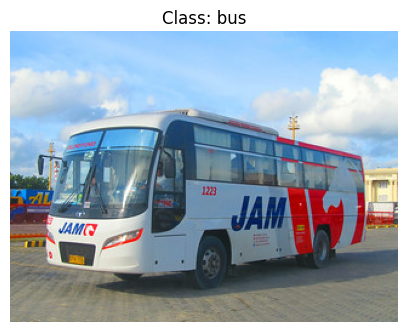

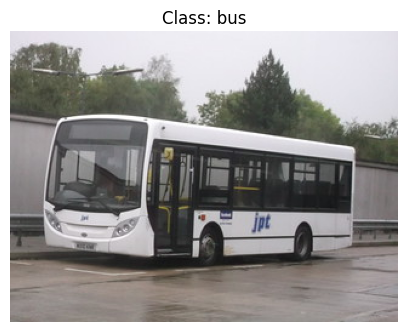

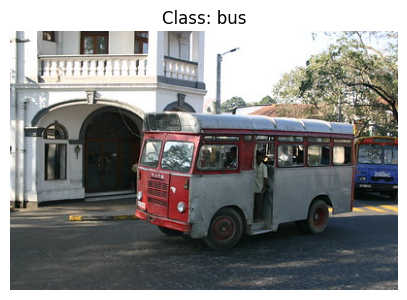

In [4]:
#Inspect a few images in the image list

# Display one image from each folder
for i in range(3): 
    plt.figure(figsize=(5, 5))
    plt.imshow(image[i])
    plt.title(f"Class: {class_name[i]}")
    plt.axis('off')
    plt.show()

In [14]:
#Going to prepare image data to work with. I will first handle the training data.

image_data = []
labels = []

class_label_mapping = {
    'bus': 0,
    'car': 1,
    'motorcycles': 2,
    'threewheel': 3,
    'truck': 4,
    'van': 5,
    'multiclass': 6
}

#go through the folders and classes in dictionary
for object_name, folder_path in class_directories.items():

        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)

            #read the image in color.
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)

            #this will only proceed if the image exists
            if img is not None:
                #resize image to fixed size so its uniform ( as most images had different heights and widths)
                img_resized = cv2.resize(img, (128,128))

                #make image interpretable for machine models by flattening it into a 1D array.
                img_flattened = img_resized.flatten()

                #add the flattened image and the label to the lists above that we instantiated.
                image_data.append(img_flattened)
                labels.append(class_label_mapping[object_name])
            else:
                print(f"The image could not be read {image_path}")

#convert the lists into numpy arrays for efficiency
image_data = np.array(image_data)
labels = np.array(labels)

In [17]:
#Convert image data to a DataFrame
df = pd.DataFrame(image_data)

#Scale data so it is more managable for machine models.
df = df / 255

# Add the labels as the target column
df['label'] = labels

df

,0,1,2,3,4,5,6,7,8,9,...,49143,49144,49145,49146,49147,49148,49149,49150,49151,label
0,0.996078,0.768627,0.545098,0.996078,0.772549,0.549020,0.996078,0.776471,0.552941,1.000000,...,0.498039,0.537255,0.517647,0.450980,0.490196,0.466667,0.482353,0.509804,0.486275,0
1,0.901961,0.866667,0.878431,0.905882,0.870588,0.882353,0.905882,0.870588,0.882353,0.913725,...,0.513725,0.521569,0.560784,0.509804,0.517647,0.556863,0.517647,0.525490,0.564706,0
2,1.000000,0.992157,1.000000,0.972549,0.992157,0.992157,0.549020,0.541176,0.517647,0.737255,...,0.443137,0.439216,0.435294,0.462745,0.466667,0.458824,0.360784,0.360784,0.360784,0
3,0.376471,0.501961,0.419608,0.415686,0.501961,0.447059,0.505882,0.549020,0.498039,0.478431,...,0.560784,0.549020,0.517647,0.552941,0.541176,0.509804,0.556863,0.545098,0.513725,0
4,0.211765,0.172549,0.400000,0.396078,0.352941,0.529412,0.333333,0.286275,0.423529,0.290196,...,0.031373,0.023529,0.019608,0.031373,0.027451,0.015686,0.035294,0.027451,0.011765,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,0.098039,0.117647,0.129412,0.117647,0.094118,0.098039,0.066667,0.062745,0.098039,0.062745,...,0.580392,0.545098,0.529412,0.560784,0.560784,0.537255,0.635294,0.619608,0.600000,6
2096,0.164706,0.345098,0.341176,0.713725,0.701961,0.662745,0.917647,0.874510,0.819608,0.772549,...,0.223529,0.278431,0.309804,0.447059,0.494118,0.529412,0.317647,0.380392,0.423529,6
2097,0.023529,0.298039,0.235294,0.211765,0.443137,0.400000,0.290196,0.462745,0.431373,0.949020,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6
2098,0.929412,0.894118,0.854902,0.929412,0.894118,0.854902,0.929412,0.894118,0.854902,0.929412,...,0.643137,0.694118,0.749020,0.654902,0.713725,0.749020,0.627451,0.686275,0.721569,6


In [18]:
#Going to create a function for "Shotgun approach" for machine learning modeling.

def classification_model_test(model, X_train, y_train, X_test, y_test):
    # Fit the model with the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate and return the accuracy score
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

    # Generate heatmap of confusion matrix
    sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred),
            annot=True,
            cmap="coolwarm",
            square=True)

    # Print classification report
    print(classification_report(y_true=y_test, y_pred=y_pred))

    return f"Accuracy Score: {accuracy:.2f}"

In [19]:
X = df.drop(columns=['label'])
y = df['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

Now that the image data has been sorted and we have training and test splits, lets employ our machine learning shotgun approach and see how our basic classifiers perform our image data.

              precision    recall  f1-score   support

           0       0.44      0.46      0.45        68
           1       0.45      0.32      0.37        78
           2       0.27      0.32      0.30        56
           3       0.31      0.33      0.32        54
           4       0.38      0.34      0.36        83
           5       0.29      0.40      0.34        58
           6       0.00      0.00      0.00        23

    accuracy                           0.34       420
   macro avg       0.31      0.31      0.31       420
weighted avg       0.35      0.34      0.34       420



'Accuracy Score: 0.34'

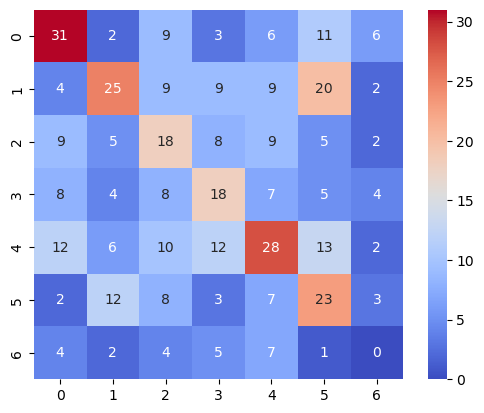

In [20]:
log_reg = LogisticRegression()
classification_model_test(log_reg, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.45      0.46      0.45        68
           1       0.51      0.33      0.40        78
           2       0.34      0.36      0.35        56
           3       0.35      0.41      0.38        54
           4       0.39      0.33      0.36        83
           5       0.30      0.50      0.37        58
           6       0.00      0.00      0.00        23

    accuracy                           0.37       420
   macro avg       0.33      0.34      0.33       420
weighted avg       0.38      0.37      0.37       420



'Accuracy Score: 0.37'

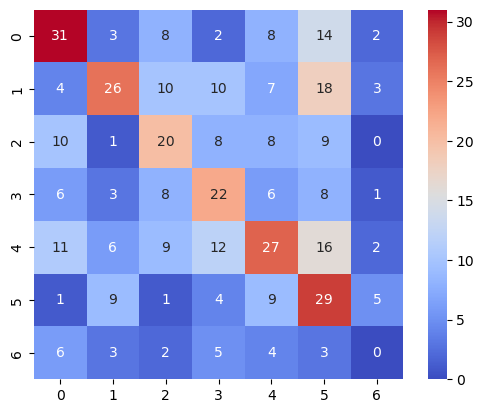

In [21]:
sgd_model = SGDClassifier()
classification_model_test(sgd_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.49      0.62      0.55        68
           1       0.46      0.51      0.48        78
           2       0.29      0.43      0.35        56
           3       0.44      0.39      0.41        54
           4       0.48      0.37      0.42        83
           5       0.49      0.43      0.46        58
           6       0.00      0.00      0.00        23

    accuracy                           0.44       420
   macro avg       0.38      0.39      0.38       420
weighted avg       0.42      0.44      0.42       420



'Accuracy Score: 0.44'

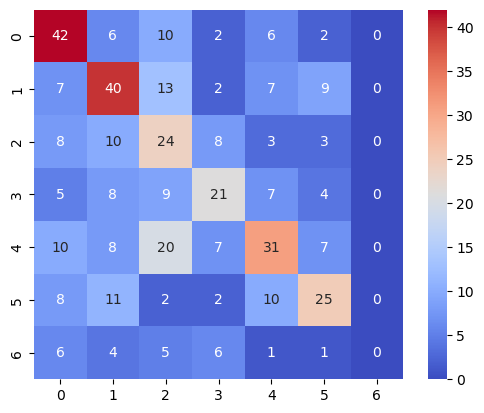

In [22]:
svc_model = SVC()
classification_model_test(svc_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.46      0.60      0.52        68
           1       0.40      0.44      0.42        78
           2       0.39      0.50      0.44        56
           3       0.47      0.48      0.48        54
           4       0.53      0.37      0.44        83
           5       0.49      0.52      0.50        58
           6       0.00      0.00      0.00        23

    accuracy                           0.45       420
   macro avg       0.39      0.42      0.40       420
weighted avg       0.43      0.45      0.44       420



'Accuracy Score: 0.45'

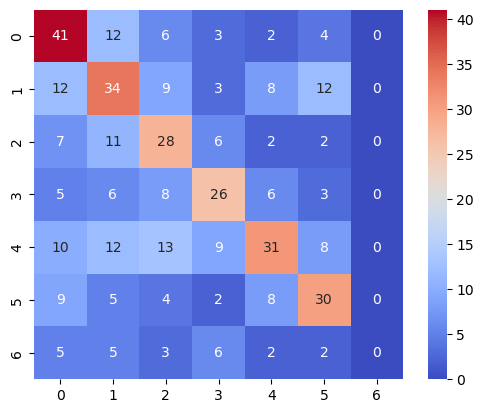

In [23]:
rfc_model = RandomForestClassifier()
classification_model_test(rfc_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.50      0.59      0.54        68
           1       0.46      0.51      0.48        78
           2       0.37      0.41      0.39        56
           3       0.41      0.46      0.43        54
           4       0.51      0.41      0.45        83
           5       0.43      0.45      0.44        58
           6       0.00      0.00      0.00        23

    accuracy                           0.45       420
   macro avg       0.38      0.40      0.39       420
weighted avg       0.43      0.45      0.44       420



'Accuracy Score: 0.45'

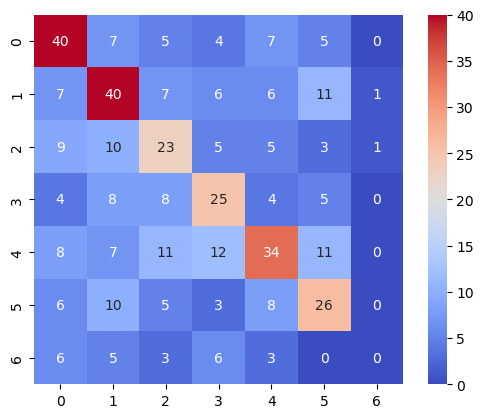

In [24]:
gbc_model = GradientBoostingClassifier()
classification_model_test(gbc_model, X_train, y_train, X_test, y_test)

After this shotgun approach on basic machine learning classifiers, it is clear that this data is very nuanced and basic ML classifiers are having trouble picking up on complex patterns within the image data. Therefore, I will employ a CNN model and train it to learn about the complex heuristics of the images.

## Section 2: Deep Learning

In the last section, I employed a shotgun approach on my image data to see if the basic classifiers are good enough at identifying classes within images. As it turns out, they were not good at predicting, as to be expected. In this section, I will develop a custom CNN network to try and predict the classes.

In [5]:
#Instancing a Sequential model
Sequential = tf.keras.models.Sequential

#CNN Network Layers
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
Flatten = tf.keras.layers.Flatten
Conv2D = tf.keras.layers.Conv2D
MaxPool2D = tf.keras.layers.MaxPool2D

#Optimizer
Adam = tf.keras.optimizers.Adam

#Image Preprocessing
ImageDataGenerator =  tf.keras.preprocessing.image.ImageDataGenerator

In [6]:
#Going to prepare image data to work with. I will first handle the training data.

cnn_image_data = []
cnn_labels = []
class_directories = {
    'bus': bus_path,
    'car': cars_path,
    'motorcycles': motorcycles_path,
    'threewheel': threewheels_path,
    'truck': trucks_path,
    'van': vans_path,
    'multiclass': multiclass_path
}

class_label_mapping = {
    'bus': 0,
    'car': 1,
    'motorcycles': 2,
    'threewheel': 3,
    'truck': 4,
    'van': 5,
    'multiclass': 6
}

#go through the folders and classes in dictionary
for object_name, folder_path in class_directories.items():

        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)

            #read the image in color.
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)

            #this will only proceed if the image exists
            if img is not None:
                #resize image to fixed size so its uniform ( as most images had different heights and widths)
                img_resized = cv2.resize(img, (128,128))

                #add the flattened image and the label to the lists above that we instantiated.
                cnn_image_data.append(img_resized)
                cnn_labels.append(class_label_mapping[object_name])
            else:
                print(f"The image could not be read {image_path}")

#convert the lists into numpy arrays for efficiency
cnn_image_data = np.array(cnn_image_data)
cnn_labels = np.array(cnn_labels)

In [7]:
#I am going to scale the image data to 0-1 range for the model.

cnn_image_data = cnn_image_data / 255.0

cnn_image_data

array([[[[0.99607843, 0.76862745, 0.54509804],
         [0.99607843, 0.77254902, 0.54901961],
         [0.99607843, 0.77647059, 0.55294118],
         ...,
         [0.99215686, 0.78431373, 0.52941176],
         [0.99215686, 0.78431373, 0.52941176],
         [0.99607843, 0.77647059, 0.5254902 ]],

        [[0.99607843, 0.76862745, 0.5372549 ],
         [0.99607843, 0.76862745, 0.5372549 ],
         [0.99215686, 0.77254902, 0.54117647],
         ...,
         [1.        , 0.78823529, 0.54117647],
         [1.        , 0.78823529, 0.54117647],
         [1.        , 0.78039216, 0.5372549 ]],

        [[1.        , 0.76862745, 0.5372549 ],
         [0.99607843, 0.76862745, 0.5372549 ],
         [0.99607843, 0.76862745, 0.5372549 ],
         ...,
         [1.        , 0.78431373, 0.54509804],
         [1.        , 0.78431373, 0.54117647],
         [1.        , 0.78039216, 0.54117647]],

        ...,

        [[0.49803922, 0.56078431, 0.57254902],
         [0.50588235, 0.56470588, 0.57254902]

In [8]:
#Split the data into training and test sets
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(cnn_image_data, cnn_labels, train_size=0.8, test_size=0.2, random_state=42)

#Image Type Forcing
X_train_cnn = X_train_cnn.astype("float32"); X_test_cnn = X_test_cnn.astype("float32")

In [9]:
#One-hot encode the labels
y_train_cnn = to_categorical(y_train_cnn, num_classes=7)
y_test_cnn = to_categorical(y_test_cnn, num_classes=7)

In [10]:
# Here I will define the network layers.
convolutional_layer_1 = Conv2D(50,
                               kernel_size=(3, 3),
                               strides=(1, 1),
                               padding="same",
                               activation="relu",
                               input_shape=(128, 128, 3))
convolutional_layer_2 = Conv2D(75,
                               kernel_size=(3, 3),
                               strides=(1, 1),
                               padding="same",
                               activation="relu")
convolutional_layer_3 = Conv2D(125,
                               kernel_size=(3, 3),
                               strides=(1, 1),
                               padding="same",
                               activation="relu")

# Two corresponding pooling layers to reduce convolved dimensionality
pooling_layer_1 =         MaxPool2D(pool_size=(2, 2))
pooling_layer_2 =         MaxPool2D(pool_size=(2, 2))

# Four dropout layers: two for the convolutions and two for the ANN
dropout_layer_1 =         Dropout(0.25)
dropout_layer_2 =         Dropout(0.25)
dropout_layer_3 =         Dropout(0.4)
dropout_layer_4 =         Dropout(0.3)

# A flattening layer for ingestion into the ANN
flattening_layer_1 =      Flatten()

# Three dense layers to make up the significant ANN architecture
connective_layer_1 =      Dense(500, activation="relu")
connective_layer_2 =      Dense(250, activation="relu")
output_layer =            Dense(7, activation="softmax")

In [11]:
# Initialize sequential model schema
model = Sequential()

# Add first convolutional feature mapping process layers
model.add(convolutional_layer_1)

# Add second convolutional feature mapping process layers
model.add(convolutional_layer_2)
model.add(pooling_layer_1)
model.add(dropout_layer_1)

# Add third convolutional feature mapping process layers
model.add(convolutional_layer_3)
model.add(pooling_layer_2)
model.add(dropout_layer_2)

# Add image vectorization process layer
model.add(flattening_layer_1)

# Add connective ANN process layers
model.add(connective_layer_1)
model.add(dropout_layer_3)
model.add(connective_layer_2)
model.add(dropout_layer_4)
model.add(output_layer)

# Summarize model layering setup
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 50)      1400      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 75)      33825     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 75)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 75)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 125)       84500     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 125)      0         
 2D)                                                    

In [12]:
#Define Adam optimization
optimizer = Adam(learning_rate=0.001)

In [22]:
#Set compilation properties
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Set epochs and batch size
epochs, batch_size = 100, 64

In [23]:
#Create image augmentation engine as generator-like object
generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
)

#Fit training data to augmentation generator
generator.fit(X_train_cnn)

In [24]:
#created this only if necessary to use. Doesn't seem like I will need this.

#Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          #this is the number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Rstores the model weights from the best epoch with the lowest validation loss
)

#Define ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(
    filepath='best_model_traffic_images.h5',  
    monitor='val_loss',        
    save_best_only=True,       
    verbose=1                  
)

In [25]:
print("Independent training set size:\t\t{}".format(X_train_cnn.shape))
print("Independent validation set size:\t{}".format(X_test_cnn.shape))
print("Target training set size:\t\t{}".format(y_train_cnn.shape))
print("Target validation set size:\t\t{}".format(y_test_cnn.shape))

Independent training set size:		(1680, 128, 128, 3)
Independent validation set size:	(420, 128, 128, 3)
Target training set size:		(1680, 7)
Target validation set size:		(420, 7)


In [26]:
# Fit model using generator-augmented dataset and mini-batch ingestion
history = model.fit(
    generator.flow(X_train_cnn,
                   y_train_cnn,
                   batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_test_cnn, y_test_cnn),
    batch_size=batch_size,
    #callbacks=[early_stopping, model_checkpoint] #This is only if the model is not learning and if something crashes, there will be a save state of performance.
)

Epoch 1/100
27/27 [==============================] - 4s 134ms/step - loss: 0.5320 - accuracy: 0.8238 - val_loss: 1.4288 - val_accuracy: 0.6286
Epoch 2/100
27/27 [==============================] - 4s 127ms/step - loss: 0.5751 - accuracy: 0.8024 - val_loss: 1.0757 - val_accuracy: 0.6857
Epoch 3/100
27/27 [==============================] - 4s 133ms/step - loss: 0.5286 - accuracy: 0.8095 - val_loss: 1.2314 - val_accuracy: 0.6595
Epoch 4/100
27/27 [==============================] - 4s 144ms/step - loss: 0.4729 - accuracy: 0.8375 - val_loss: 1.2873 - val_accuracy: 0.6643
Epoch 5/100
27/27 [==============================] - 4s 139ms/step - loss: 0.5196 - accuracy: 0.8143 - val_loss: 1.1224 - val_accuracy: 0.6643
Epoch 6/100
27/27 [==============================] - 4s 130ms/step - loss: 0.4984 - accuracy: 0.8185 - val_loss: 1.1524 - val_accuracy: 0.6833
Epoch 7/100
27/27 [==============================] - 4s 128ms/step - loss: 0.4905 - accuracy: 0.8286 - val_loss: 1.0965 - val_accuracy: 0.6976

In [27]:
#Let's visualize the results
def plot_training_results(history):
    """
    Visualize results of the model training using `matplotlib`.

    The visualization will include charts for accuracy and loss,
    on the training and as well as validation data sets.

    INPUTS:
        history(tf.keras.callbacks.History):
            Contains data on how the model metrics changed
            over the course of training.

    OUTPUTS:
        None.
    """
    # Get accuracy for training and validation sets
    accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Get loss for training and validation sets
    loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Get range of epochs to produce common plotting range
    epochs_range = range(epochs)

    # Instantiate plotting figure space
    plt.figure(figsize=(20, 8))

    # Create training/validation accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Create training/validation loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Render visualization
    plt.show()

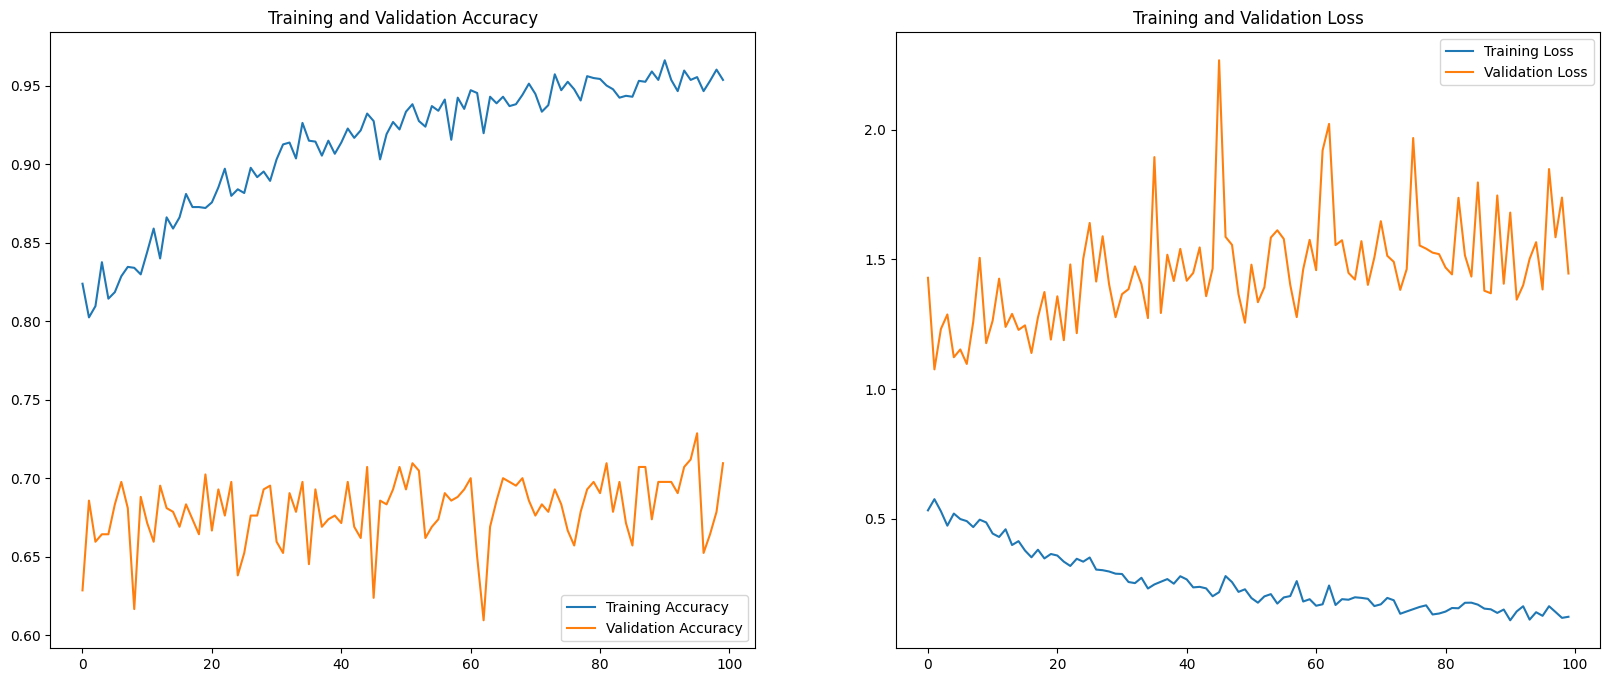

In [28]:
# Visualize accuracy and loss for training and validation datasets
plot_training_results(history)

14/14 [==============================] - 0s 28ms/step


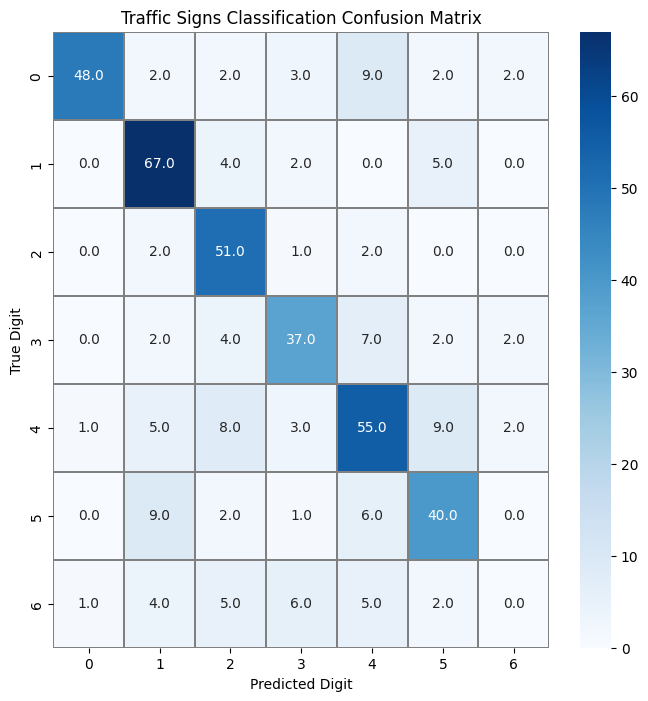

In [29]:
# Get predicted class values from fitted model
y_pred = model.predict(X_test_cnn)

# Get class distributions for predicted and true class values
y_pred_classes =  np.argmax(y_pred, axis=1)
y_true =          np.argmax(y_test_cnn, axis=1)

# Create confusion matrix object from class distributions
cmat = confusion_matrix(y_true, y_pred_classes)

# Render confusion matrix as heatmap visualization
figure, axis = plt.subplots(figsize=(8, 8))
sns.heatmap(cmat,
            annot=True,
            linewidths=0.01,
            cmap="Blues",
            linecolor="gray",
            fmt=".1f",
            ax=axis)
plt.xlabel("Predicted Digit")
plt.ylabel("True Digit")
plt.title("Traffic Signs Classification Confusion Matrix")
plt.show()

The CNN network did a good job predicting classes that had only 1 object in it (such as one car, truck, bus, motorcycle etc.), but as soon as I introduced multiclass images (such as car, motorcycle, truck all in one image), it could not pick it up at all. So although it did good, it's not very practical for real world use. Therefore, I will work on training a custom YOLO v8 detection model.

## Section 3: YOLO Model Training

In this section, I will organize my data in a format that is appropriate for the YOLO model. This will entail putting all of the class images into one folder for training, one folder for validation, and going through each images JSON file to get the class of the corresponding image and the dimensions of where the bounding box should go so the model can learn for both training and validation images. Lets get started.

In [13]:
static_directory = Path(r"C:\Users\chris\Desktop\capstone project\Traffic_Vehicle_Real_Time_Detection\source")

In [36]:
#Here I am going through all of the annotation files and and getting the coordinates for the bounding boxes. 
# It will be normalized so the model can interpret it.


# Set paths
class_directories = {
    'bus': bus_path,
    'car': cars_path,
    'motorcycles': motorcycles_path,
    'threewheel': threewheels_path,
    'truck': trucks_path,
    'van': vans_path,
    'annotations': annotations_path
}

#Ensure output folder exists Note: Please update the static directory to a  path in your local directory.
output_folder = static_directory / "train" / "yolo_annotations"
os.makedirs(output_folder, exist_ok=True)

#Define the label mapping (YOLO requires numerical labels)
class_label_mapping = {
    'bus': 0,
    'car': 1,
    'motorbike': 2,
    'threewheel': 3,
    'truck': 4,
    'van': 5,
}

#Loop through all JSON files in the annotations folder
for json_file in os.listdir(class_directories['annotations']):
    if json_file.endswith('.json'):
        json_path = os.path.join(class_directories['annotations'], json_file)
        
        # Load the JSON data
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        # Get image dimensions
        img_height = data['size']['height']
        img_width = data['size']['width']
        
        # Prepare to write to a YOLO annotation file
        txt_file = os.path.join(output_folder, json_file.replace('.json', '.txt'))
        
        # Open the output file to write the annotations
        with open(txt_file, 'w') as txt_out:
            # Track unique classes in this file
            unique_classes = []

            # First pass to collect unique classes
            for obj in data['objects']:
                class_title = obj['classTitle']
                if class_title in class_label_mapping:
                    unique_classes.append(class_title)
            
            # Second pass to write annotations
            for obj in data['objects']:
                class_title = obj['classTitle']
                
                if class_title in class_label_mapping:
                    class_id = class_label_mapping[class_title]

                    # Extract bounding box points
                    x_min, y_min = obj['points']['exterior'][0]
                    x_max, y_max = obj['points']['exterior'][1]
                    
                    # Normalize coordinates (YOLO expects values between 0 and 1)
                    center_x = (x_min + x_max) / 2 / img_width
                    center_y = (y_min + y_max) / 2 / img_height
                    width = (x_max - x_min) / img_width
                    height = (y_max - y_min) / img_height

                    # If more than one unique class, write each class separately
                    if len(set(unique_classes)) > 1:
                        # Write entry for the actual class ID
                        txt_out.write(f"{class_id} {center_x:.6f} {center_y:.6f} {width:.6f} {height:.6f}\n")
                    else:
                        # Write normally for single class
                        txt_out.write(f"{class_id} {center_x:.6f} {center_y:.6f} {width:.6f} {height:.6f}\n")

I also have to do the same with the validation images. 

In [2]:
# Paths for validation annotations and images
validation_annotations_path = static_directory / "valid" / "ann"
validation_images_path = static_directory / "valid" / "images"

# Ensure output folder for validation annotations exists
validation_output_folder = static_directory / "valid" / "yolo_annotations"
os.makedirs(validation_output_folder, exist_ok=True)

# Define the label mapping (YOLO requires numerical labels)
class_label_mapping = {
    'bus': 0,
    'car': 1,
    'motorbike': 2,
    'threewheel': 3,
    'truck': 4,
    'van': 5,
}

# Loop through all JSON files in the validation annotations folder
for json_file in os.listdir(validation_annotations_path):
    if json_file.endswith('.json'):
        json_path = os.path.join(validation_annotations_path, json_file)
        
        # Load the JSON data
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        # Get image dimensions
        img_height = data['size']['height']
        img_width = data['size']['width']
        
        # Prepare to write to a YOLO annotation file for validation
        txt_file = os.path.join(validation_output_folder, json_file.replace('.json', '.txt'))
        
        # Open the output file to write the annotations
        with open(txt_file, 'w') as txt_out:
            # Track unique classes in this file
            unique_classes = []

            # First pass to collect unique classes
            for obj in data['objects']:
                class_title = obj['classTitle']
                if class_title in class_label_mapping:
                    unique_classes.append(class_title)
            
            # Second pass to write annotations
            for obj in data['objects']:
                class_title = obj['classTitle']
                
                if class_title in class_label_mapping:
                    class_id = class_label_mapping[class_title]

                    # Extract bounding box points
                    x_min, y_min = obj['points']['exterior'][0]
                    x_max, y_max = obj['points']['exterior'][1]
                    
                    # Normalize coordinates (YOLO expects values between 0 and 1)
                    center_x = (x_min + x_max) / 2 / img_width
                    center_y = (y_min + y_max) / 2 / img_height
                    width = (x_max - x_min) / img_width
                    height = (y_max - y_min) / img_height

                    # If more than one unique class, write each class separately
                    if len(set(unique_classes)) > 1:
                        # Write entry for the actual class ID
                        txt_out.write(f"{class_id} {center_x:.6f} {center_y:.6f} {width:.6f} {height:.6f}\n")
                    else:
                        # Write normally for single class
                        txt_out.write(f"{class_id} {center_x:.6f} {center_y:.6f} {width:.6f} {height:.6f}\n")

print("Validation annotations processed and saved in YOLO format.")

Validation annotations processed and saved in YOLO format.


Because the images were saved as the images name.jpg or another format, I need to remove the file extension from the name so the YOLO model can work with the annotation text documents.

In [5]:
# Path for labels
label_folder = static_directory / "train" / "labels" 

# Loop through all .txt files in the label folder
for filename in os.listdir(label_folder):
    # Check for and remove .jpg.txt, .jpeg.txt, and .png.txt extensions
    if filename.endswith('.jpg.txt'):
        new_filename = filename.replace('.jpg.txt', '.txt')
        os.rename(os.path.join(label_folder, filename), os.path.join(label_folder, new_filename))
    elif filename.endswith('.jpeg.txt'):
        new_filename = filename.replace('.jpeg.txt', '.txt')
        os.rename(os.path.join(label_folder, filename), os.path.join(label_folder, new_filename))
    elif filename.endswith('.png.txt'):
        new_filename = filename.replace('.png.txt', '.txt')
        os.rename(os.path.join(label_folder, filename), os.path.join(label_folder, new_filename))

print("Renaming complete!")

Renaming complete!


I will do the same with the validation image labels.

In [15]:
label_folder = static_directory / "valid" / "labels"
label_folder

WindowsPath('C:/Users/chris/Desktop/capstone project/Traffic_Vehicle_Real_Time_Detection/source/valid/labels')

In [18]:
# Path to your label folder (replace this with the actual path)
label_folder = static_directory / "valid" / "labels"

# Loop through all .txt files in the label folder
for filename in os.listdir(label_folder):
    # Check for and remove .jpg.txt, .jpeg.txt, and .png.txt extensions
    if filename.endswith('.jpg.txt'):
        new_filename = filename.replace('.jpg.txt', '.txt')
        os.rename(os.path.join(label_folder, filename), os.path.join(label_folder, new_filename))
    elif filename.endswith('.jpeg.txt'):
        new_filename = filename.replace('.jpeg.txt', '.txt')
        os.rename(os.path.join(label_folder, filename), os.path.join(label_folder, new_filename))
    elif filename.endswith('.png.txt'):
        new_filename = filename.replace('.png.txt', '.txt')
        os.rename(os.path.join(label_folder, filename), os.path.join(label_folder, new_filename))

print("Renaming complete!")

Renaming complete!


Now I will import the yolo model and train it on my dataset.

After training the model on my original image dataset, it did exceptionally well at identifying cars, motorcycles, trucks, vans, and tricycles. However, after introducing some images of buses, it was miscategorizing buses as trucks. As a result, I have went and found many more images of buses and trucks and trained the model on many more epochs to learn the interesting nuances of each class. The original dataset had trucks that were european style trucks, which are cabover style, which are very rectangular. This is likely making it difficult for the model to distinguish the differences between trucks and buses due to their similar shape and structure. As I have found more images to train the model on, I will retrain the model on more images and more epochs to evaluate how it will perform.

Below are the additional image datasets in which I have used to further train my model:

https://universe.roboflow.com/withaugmentation/buss_aug_train

https://universe.roboflow.com/aun-clavis/bus-yq0il

https://universe.roboflow.com/pruebas-de-200/truck-mx7ds

I will also have basic imports to train my yolo model below so I can quickly train it and evaluate the model

In [1]:
import torch

In [4]:
from ultralytics import YOLO

#Load the model
model = YOLO('yolov8n.pt')

#Train the model Note: Update the path to your local 
model.train(data=static_directory / "data.yaml", epochs=400, imgsz=640)

New https://pypi.org/project/ultralytics/8.3.1 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.100  Python-3.9.19 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:\Users\chris\Desktop\capstone project\Traffic_Vehicle_Real_Time_Detection\source\data.yaml, epochs=400, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=Fa

train: Scanning C:\Users\chris\Desktop\capstone project\Traffic_Vehicle_Real_Time_Detection\source\train\labels... 2886 images, 1 backgrounds, 0 corrupt: 100%|██████████| 2886/2886 [00:01<00:00, 2783.23it/s]

train: WARNING  C:\Users\chris\Desktop\capstone project\Traffic_Vehicle_Real_Time_Detection\source\train\images\71b258004d677b5f_jpg.rf.bb24a02bf5f3f7b312d3f3407bda46d9.jpg: 1 duplicate labels removed


train: New cache created: C:\Users\chris\Desktop\capstone project\Traffic_Vehicle_Real_Time_Detection\source\train\labels.cache
WARNING  Box and segment counts should be equal, but got len(segments) = 247, len(boxes) = 3760. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


val: Scanning C:\Users\chris\Desktop\capstone project\Traffic_Vehicle_Real_Time_Detection\source\valid\labels... 936 images, 0 backgrounds, 0 corrupt: 100%|██████████| 936/936 [00:00<00:00, 1357.13it/s]


val: New cache created: C:\Users\chris\Desktop\capstone project\Traffic_Vehicle_Real_Time_Detection\source\valid\labels.cache
WARNING  Box and segment counts should be equal, but got len(segments) = 45, len(boxes) = 1195. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train3
Starting training for 400 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/400      2.15G     0.7394      2.585      1.246         21        640: 100%|██████████| 181/181 [00:19<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  6.88it/s]


                   all        936       1195      0.647       0.74      0.757      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/400      2.14G     0.7747      1.633      1.238         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.80it/s]


                   all        936       1195      0.767       0.76      0.838      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/400      2.14G     0.8285      1.488      1.261         21        640: 100%|██████████| 181/181 [00:22<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.12it/s]


                   all        936       1195      0.749       0.71      0.792      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/400      2.14G      0.903      1.486      1.319         23        640: 100%|██████████| 181/181 [00:18<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


                   all        936       1195      0.773       0.73      0.814      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/400      2.14G     0.8855      1.363      1.295         26        640: 100%|██████████| 181/181 [00:17<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.75it/s]


                   all        936       1195      0.788      0.727      0.832      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/400      2.14G     0.8875       1.27      1.309         25        640: 100%|██████████| 181/181 [00:17<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]

                   all        936       1195      0.775       0.76      0.827       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/400      2.14G     0.8513      1.159      1.272         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.93it/s]

                   all        936       1195      0.772      0.745      0.812      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/400      2.13G     0.8423      1.099      1.273         16        640: 100%|██████████| 181/181 [00:17<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.79it/s]

                   all        936       1195       0.81      0.745      0.844      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/400      2.13G     0.8305      1.044      1.265         14        640: 100%|██████████| 181/181 [00:18<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.84it/s]

                   all        936       1195      0.841      0.763      0.857        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/400      2.13G     0.8095     0.9872       1.25         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.00it/s]

                   all        936       1195      0.843      0.778      0.891      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/400      2.14G     0.8045     0.9706      1.239         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.89it/s]

                   all        936       1195      0.908      0.821      0.897      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/400      2.26G     0.7824     0.9416      1.227         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.21it/s]

                   all        936       1195      0.876      0.819      0.891      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/400      2.13G     0.7807     0.9168      1.229         19        640: 100%|██████████| 181/181 [00:19<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.28it/s]

                   all        936       1195      0.871      0.815      0.897      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/400      2.13G     0.7569     0.8705      1.206         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.19it/s]

                   all        936       1195      0.889      0.853      0.925      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/400      2.13G     0.7603     0.8748      1.212         14        640: 100%|██████████| 181/181 [00:16<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.22it/s]

                   all        936       1195      0.883      0.831      0.923       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/400      2.13G      0.751     0.8498      1.201         19        640: 100%|██████████| 181/181 [00:18<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.29it/s]

                   all        936       1195      0.861       0.85      0.929      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/400      2.13G     0.7326     0.8382      1.191         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.44it/s]

                   all        936       1195      0.885      0.831      0.913       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/400      2.26G     0.7289     0.8183      1.188         31        640: 100%|██████████| 181/181 [00:17<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.25it/s]

                   all        936       1195      0.936      0.844      0.937      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/400      2.27G     0.7178     0.7779      1.183         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.30it/s]

                   all        936       1195      0.925      0.872      0.947      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/400      2.13G     0.7379     0.8108      1.196         13        640: 100%|██████████| 181/181 [00:17<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.39it/s]

                   all        936       1195      0.923       0.88      0.942      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/400      2.13G     0.7038     0.7637       1.17         14        640: 100%|██████████| 181/181 [00:17<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.23it/s]

                   all        936       1195      0.927       0.88      0.943       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/400      2.13G     0.6992     0.7626      1.171         23        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.36it/s]

                   all        936       1195      0.918      0.891      0.946       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/400      2.13G     0.6997     0.7489       1.17         15        640: 100%|██████████| 181/181 [00:17<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.28it/s]

                   all        936       1195      0.944      0.877      0.948      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/400      2.13G     0.7006     0.7399      1.168         14        640: 100%|██████████| 181/181 [00:17<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.19it/s]

                   all        936       1195      0.912      0.854      0.934      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/400      2.13G      0.691     0.7203      1.165         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.29it/s]

                   all        936       1195      0.921      0.872      0.944      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/400      2.26G     0.6757     0.7146      1.151         21        640: 100%|██████████| 181/181 [00:17<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.40it/s]

                   all        936       1195      0.937      0.884      0.952      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/400      2.13G     0.6767     0.7109      1.151         25        640: 100%|██████████| 181/181 [00:18<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.99it/s]

                   all        936       1195      0.932      0.882      0.953      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/400      2.13G     0.6733     0.7013      1.157         29        640: 100%|██████████| 181/181 [00:17<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.35it/s]

                   all        936       1195      0.941      0.867      0.939      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/400      2.13G     0.6592     0.6735      1.146         25        640: 100%|██████████| 181/181 [00:17<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.20it/s]

                   all        936       1195      0.948      0.886      0.948      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/400      2.27G     0.6684     0.6843      1.145         21        640: 100%|██████████| 181/181 [00:17<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.40it/s]

                   all        936       1195      0.943      0.909      0.959      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/400      2.13G     0.6548     0.6769      1.143         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.28it/s]

                   all        936       1195      0.927      0.904      0.945      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/400      2.26G     0.6677     0.6826       1.15         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.40it/s]

                   all        936       1195      0.924        0.9      0.954      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/400      2.13G     0.6504     0.6711      1.138         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.38it/s]

                   all        936       1195      0.926      0.902      0.951       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/400      2.27G     0.6495     0.6637       1.14         15        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.35it/s]

                   all        936       1195      0.957      0.892       0.96       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/400      2.13G     0.6442     0.6504      1.135         15        640: 100%|██████████| 181/181 [00:17<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.35it/s]

                   all        936       1195      0.953      0.907      0.962      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/400      2.13G     0.6375     0.6378      1.133         16        640: 100%|██████████| 181/181 [00:17<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.34it/s]

                   all        936       1195      0.928       0.92       0.96       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/400      2.13G     0.6307     0.6343      1.125         25        640: 100%|██████████| 181/181 [00:17<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.06it/s]

                   all        936       1195      0.964      0.899      0.962      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/400      2.13G     0.6304     0.6392      1.126         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.45it/s]

                   all        936       1195      0.942      0.896      0.951      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/400      2.13G     0.6283     0.6309      1.122         14        640: 100%|██████████| 181/181 [00:17<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.42it/s]

                   all        936       1195      0.953       0.89      0.956      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/400      2.13G      0.629     0.6118      1.118         16        640: 100%|██████████| 181/181 [00:17<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.09it/s]

                   all        936       1195      0.965      0.907      0.969       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/400      2.27G     0.6328     0.6246      1.122         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.43it/s]

                   all        936       1195      0.934      0.918      0.968      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/400      2.13G     0.6251     0.6159      1.121         15        640: 100%|██████████| 181/181 [00:17<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.38it/s]

                   all        936       1195      0.948      0.926      0.972      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/400      2.13G     0.6159     0.6019      1.111         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.13it/s]

                   all        936       1195      0.975      0.886      0.967      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/400      2.13G     0.6051     0.5919      1.112         22        640: 100%|██████████| 181/181 [00:19<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.15it/s]

                   all        936       1195      0.954      0.894       0.96      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/400      2.13G     0.6037     0.5991      1.109         24        640: 100%|██████████| 181/181 [00:18<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.37it/s]

                   all        936       1195      0.953      0.899      0.963      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/400      2.13G     0.6178     0.5995       1.11         16        640: 100%|██████████| 181/181 [00:17<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.12it/s]

                   all        936       1195      0.952      0.906      0.959      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/400      2.13G     0.6045     0.5875      1.108         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.37it/s]

                   all        936       1195      0.965        0.9       0.96      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/400      2.13G      0.615     0.5914      1.111         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.41it/s]

                   all        936       1195      0.953      0.912      0.966      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/400      2.13G     0.6034     0.5844      1.109         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.37it/s]

                   all        936       1195      0.952      0.904      0.966      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/400      2.13G     0.6066     0.5853      1.113         23        640: 100%|██████████| 181/181 [00:18<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.14it/s]

                   all        936       1195      0.952      0.896      0.963      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/400      2.13G     0.6075     0.5827       1.11         26        640: 100%|██████████| 181/181 [00:17<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.27it/s]

                   all        936       1195      0.964      0.904      0.967      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/400      2.13G      0.588     0.5643      1.096         21        640: 100%|██████████| 181/181 [00:18<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.39it/s]

                   all        936       1195      0.959      0.914      0.967       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/400      2.13G     0.5995     0.5696      1.099         11        640: 100%|██████████| 181/181 [00:17<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.39it/s]

                   all        936       1195      0.956      0.896      0.958      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/400      2.13G      0.596     0.5752      1.101         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.13it/s]

                   all        936       1195      0.952      0.918      0.967      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/400      2.13G     0.5979     0.5669      1.103         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.21it/s]

                   all        936       1195      0.961      0.915      0.964      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/400      2.26G     0.5859     0.5527      1.099         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.36it/s]

                   all        936       1195      0.946      0.939       0.97      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/400      2.27G     0.5865     0.5729      1.098         15        640: 100%|██████████| 181/181 [00:18<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.27it/s]

                   all        936       1195      0.956      0.925      0.966      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/400      2.13G     0.5861     0.5578        1.1         15        640: 100%|██████████| 181/181 [00:17<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.12it/s]

                   all        936       1195      0.935      0.917      0.962      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/400      2.27G     0.5844     0.5467      1.097         13        640: 100%|██████████| 181/181 [00:17<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.39it/s]

                   all        936       1195      0.955      0.903      0.963      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/400      2.13G     0.5655     0.5431      1.088         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.41it/s]

                   all        936       1195      0.942      0.932      0.969      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/400      2.13G     0.5818     0.5549      1.091         15        640: 100%|██████████| 181/181 [00:17<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.33it/s]

                   all        936       1195       0.96       0.91      0.967      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/400      2.13G     0.5767     0.5463       1.09         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.34it/s]

                   all        936       1195      0.958      0.918      0.969      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/400      2.13G     0.5803     0.5401      1.098         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.32it/s]

                   all        936       1195      0.942      0.917      0.967      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/400      2.13G     0.5704     0.5252      1.083         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.39it/s]

                   all        936       1195      0.958      0.929      0.968      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/400      2.26G     0.5674     0.5394      1.087         19        640: 100%|██████████| 181/181 [00:18<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.32it/s]

                   all        936       1195      0.971      0.914      0.967      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/400      2.27G     0.5697     0.5317      1.091         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.38it/s]

                   all        936       1195      0.953      0.924      0.965      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/400      2.13G     0.5628      0.526      1.082         25        640: 100%|██████████| 181/181 [00:17<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.38it/s]

                   all        936       1195      0.952      0.931      0.971      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/400      2.13G     0.5626     0.5296      1.084         21        640: 100%|██████████| 181/181 [00:18<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.36it/s]

                   all        936       1195      0.962       0.92       0.97      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/400      2.27G     0.5619     0.5289      1.087         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.38it/s]

                   all        936       1195      0.962      0.929      0.972      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/400      2.13G     0.5651     0.5282      1.086         16        640: 100%|██████████| 181/181 [00:17<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.34it/s]

                   all        936       1195      0.973      0.905      0.971      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/400      2.13G      0.559     0.5213      1.081         15        640: 100%|██████████| 181/181 [00:18<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.26it/s]

                   all        936       1195      0.948      0.931      0.973      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/400      2.13G     0.5616      0.525      1.075         25        640: 100%|██████████| 181/181 [00:17<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.51it/s]

                   all        936       1195      0.959      0.922      0.971      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/400      2.13G     0.5556     0.5167      1.078         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.40it/s]

                   all        936       1195       0.95      0.929      0.971      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/400      2.13G     0.5528     0.5031      1.074         28        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.46it/s]

                   all        936       1195      0.961      0.913      0.966      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/400      2.13G     0.5593      0.509       1.08         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.24it/s]

                   all        936       1195      0.958      0.941      0.975      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/400      2.26G     0.5431     0.4973      1.074         13        640: 100%|██████████| 181/181 [00:17<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.39it/s]

                   all        936       1195      0.944      0.934       0.97      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/400      2.13G     0.5468      0.503      1.073         14        640: 100%|██████████| 181/181 [00:17<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.38it/s]

                   all        936       1195      0.965      0.928      0.972      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/400      2.27G     0.5488     0.5002      1.068         13        640: 100%|██████████| 181/181 [00:18<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.44it/s]

                   all        936       1195      0.953      0.929      0.969      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/400      2.13G     0.5531      0.503      1.072         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.24it/s]

                   all        936       1195      0.963      0.926      0.971      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/400      2.26G     0.5417     0.4953      1.064         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.37it/s]

                   all        936       1195      0.966      0.923      0.973      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/400      2.13G     0.5373     0.4938      1.067         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.39it/s]

                   all        936       1195      0.966      0.904      0.972      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/400      2.13G     0.5328      0.488      1.058         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.37it/s]

                   all        936       1195       0.96       0.93      0.974      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/400      2.13G     0.5424     0.4945      1.069         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.33it/s]

                   all        936       1195       0.97      0.923      0.975      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/400      2.13G      0.539     0.4986      1.069         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.08it/s]

                   all        936       1195      0.958      0.922      0.972      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/400      2.13G     0.5277     0.4844      1.059         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.48it/s]

                   all        936       1195      0.964      0.924       0.97      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/400      2.26G     0.5349     0.4813      1.061         21        640: 100%|██████████| 181/181 [00:18<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.34it/s]

                   all        936       1195       0.96      0.925      0.972      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/400      2.26G     0.5374      0.476      1.066         24        640: 100%|██████████| 181/181 [00:17<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.04it/s]

                   all        936       1195      0.961      0.937      0.972      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/400      2.13G     0.5363     0.4853      1.063         24        640: 100%|██████████| 181/181 [00:17<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.45it/s]

                   all        936       1195      0.962      0.926      0.975      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/400      2.13G     0.5345     0.4889      1.061         14        640: 100%|██████████| 181/181 [00:18<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.32it/s]

                   all        936       1195      0.958      0.919      0.969      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/400      2.27G     0.5284     0.4784      1.058         23        640: 100%|██████████| 181/181 [00:17<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.23it/s]

                   all        936       1195      0.965      0.932      0.972      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/400      2.13G     0.5284     0.4732      1.059         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.32it/s]

                   all        936       1195      0.956      0.927      0.969       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/400      2.26G     0.5272     0.4886      1.055         23        640: 100%|██████████| 181/181 [00:17<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.50it/s]

                   all        936       1195      0.964      0.946      0.977      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/400      2.13G      0.527     0.4722      1.058         16        640: 100%|██████████| 181/181 [00:17<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.38it/s]

                   all        936       1195      0.959      0.933      0.975      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/400      2.13G     0.5174     0.4637      1.049         24        640: 100%|██████████| 181/181 [00:18<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.29it/s]

                   all        936       1195      0.967       0.92      0.972      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/400      2.13G      0.526     0.4686      1.058         20        640: 100%|██████████| 181/181 [00:18<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.27it/s]

                   all        936       1195      0.957      0.937      0.975      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/400      2.13G     0.5166     0.4653      1.053         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.21it/s]

                   all        936       1195      0.963      0.932      0.973      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/400      2.13G     0.5155     0.4698      1.052         21        640: 100%|██████████| 181/181 [00:18<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.46it/s]

                   all        936       1195      0.963      0.932      0.975      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/400      2.13G     0.5186     0.4655      1.046         28        640: 100%|██████████| 181/181 [00:18<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  6.09it/s]

                   all        936       1195      0.968      0.924       0.97      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/400      2.27G     0.5121     0.4499      1.048         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.10it/s]

                   all        936       1195      0.963      0.936      0.974      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/400      2.13G      0.514     0.4625      1.053         17        640: 100%|██████████| 181/181 [00:18<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.41it/s]

                   all        936       1195      0.974      0.929      0.977      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/400      2.13G      0.508      0.459      1.043         15        640: 100%|██████████| 181/181 [00:18<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.27it/s]

                   all        936       1195      0.977      0.937      0.977      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/400      2.13G     0.5131     0.4603      1.052         14        640: 100%|██████████| 181/181 [00:17<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.22it/s]

                   all        936       1195      0.965       0.93      0.974       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/400      2.13G     0.5159     0.4607      1.048         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.26it/s]

                   all        936       1195      0.967       0.93      0.974      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/400      2.13G     0.5112     0.4523      1.049         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.47it/s]

                   all        936       1195      0.966      0.935      0.976       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/400      2.13G     0.5013     0.4524      1.043         14        640: 100%|██████████| 181/181 [00:17<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.99it/s]

                   all        936       1195      0.962       0.93      0.972      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/400      2.13G     0.5098     0.4517      1.046         14        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.24it/s]

                   all        936       1195      0.948      0.927      0.973      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/400      2.13G     0.5077     0.4533      1.044         21        640: 100%|██████████| 181/181 [00:17<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.47it/s]

                   all        936       1195       0.96      0.928      0.971      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/400      2.26G     0.5062     0.4471      1.045         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.31it/s]

                   all        936       1195      0.959      0.928      0.972      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/400      2.13G     0.5153     0.4479      1.048         17        640: 100%|██████████| 181/181 [00:18<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.40it/s]

                   all        936       1195      0.957      0.936      0.974      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/400      2.13G     0.5017     0.4371      1.041         15        640: 100%|██████████| 181/181 [00:17<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.33it/s]

                   all        936       1195      0.957      0.923      0.969      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/400      2.13G     0.5092     0.4488      1.043         23        640: 100%|██████████| 181/181 [00:17<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.30it/s]

                   all        936       1195      0.958      0.922      0.973      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/400      2.13G     0.5012     0.4441      1.041         21        640: 100%|██████████| 181/181 [00:18<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.43it/s]

                   all        936       1195      0.963      0.936      0.976      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/400      2.13G     0.5026     0.4434      1.044         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.42it/s]

                   all        936       1195      0.954      0.935      0.972      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/400      2.13G     0.4941     0.4394      1.035         16        640: 100%|██████████| 181/181 [00:17<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.40it/s]

                   all        936       1195      0.968      0.931      0.971       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/400      2.13G     0.5048     0.4436      1.041         21        640: 100%|██████████| 181/181 [00:17<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.45it/s]

                   all        936       1195      0.954       0.94      0.975      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/400      2.13G     0.4988     0.4401      1.043         14        640: 100%|██████████| 181/181 [00:17<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.27it/s]

                   all        936       1195      0.959       0.93      0.975      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/400      2.13G     0.4968     0.4401      1.038         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.36it/s]

                   all        936       1195      0.969      0.937      0.974      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/400      2.13G     0.4961     0.4328      1.035         19        640: 100%|██████████| 181/181 [00:18<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.35it/s]

                   all        936       1195       0.95      0.941      0.972      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/400      2.13G     0.4974     0.4297      1.035         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.34it/s]

                   all        936       1195      0.971      0.921      0.975      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/400      2.26G     0.4929     0.4378      1.037         16        640: 100%|██████████| 181/181 [00:17<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.32it/s]

                   all        936       1195       0.97      0.937      0.974      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/400      2.27G     0.4844     0.4268      1.032         14        640: 100%|██████████| 181/181 [00:18<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.43it/s]

                   all        936       1195      0.968       0.93      0.974       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/400      2.13G       0.49     0.4287      1.036         14        640: 100%|██████████| 181/181 [00:17<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.91it/s]

                   all        936       1195      0.971      0.923      0.975      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/400      2.13G     0.5014     0.4432      1.038         21        640: 100%|██████████| 181/181 [00:18<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.37it/s]

                   all        936       1195      0.977      0.929      0.978      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/400      2.13G     0.4963     0.4308      1.034         11        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.39it/s]

                   all        936       1195      0.976      0.933      0.975      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/400      2.13G      0.491     0.4367      1.036         18        640: 100%|██████████| 181/181 [00:18<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.25it/s]

                   all        936       1195       0.97       0.93      0.975      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/400      2.13G     0.4919     0.4243      1.037         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.38it/s]

                   all        936       1195      0.973      0.929      0.977      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/400      2.13G     0.4848     0.4294      1.032         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.52it/s]

                   all        936       1195      0.975      0.915      0.974      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/400      2.13G     0.4873     0.4179      1.035         17        640: 100%|██████████| 181/181 [00:16<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.16it/s]

                   all        936       1195      0.957      0.943      0.975      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/400      2.13G     0.4866      0.417      1.035         14        640: 100%|██████████| 181/181 [00:16<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.46it/s]

                   all        936       1195      0.968      0.936      0.977      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/400      2.13G     0.4831     0.4249      1.027         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.40it/s]

                   all        936       1195      0.974      0.927      0.975      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/400      2.13G     0.4818     0.4179       1.03         14        640: 100%|██████████| 181/181 [00:17<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.30it/s]

                   all        936       1195      0.967      0.937      0.975      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/400      2.13G      0.486     0.4191      1.035         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.37it/s]

                   all        936       1195      0.964      0.939      0.976      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/400      2.26G     0.4876     0.4259      1.031         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.28it/s]

                   all        936       1195      0.973      0.934      0.976      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/400      2.26G     0.4814     0.4168      1.029         21        640: 100%|██████████| 181/181 [00:17<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.31it/s]

                   all        936       1195      0.965      0.932      0.972      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/400      2.13G     0.4792     0.4165      1.026         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.43it/s]

                   all        936       1195      0.977      0.926      0.977      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/400      2.13G     0.4817     0.4142      1.029         17        640: 100%|██████████| 181/181 [00:16<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.13it/s]

                   all        936       1195      0.975      0.927      0.975      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/400      2.27G     0.4839     0.4133      1.023         23        640: 100%|██████████| 181/181 [00:17<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.35it/s]

                   all        936       1195      0.977       0.93      0.976      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/400      2.13G     0.4764     0.4102      1.028         16        640: 100%|██████████| 181/181 [00:16<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.32it/s]

                   all        936       1195      0.973      0.933      0.975      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/400      2.13G     0.4717     0.4038       1.02         25        640: 100%|██████████| 181/181 [00:17<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.38it/s]

                   all        936       1195      0.972      0.934      0.977      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/400      2.13G     0.4806     0.4183      1.029         24        640: 100%|██████████| 181/181 [00:17<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.35it/s]

                   all        936       1195       0.97      0.937      0.978        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/400      2.13G     0.4788     0.4079      1.026         12        640: 100%|██████████| 181/181 [00:17<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.96it/s]

                   all        936       1195      0.974      0.929      0.977      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/400      2.27G     0.4664     0.4059      1.023         16        640: 100%|██████████| 181/181 [00:16<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.24it/s]

                   all        936       1195      0.958      0.947      0.979      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/400      2.27G     0.4753     0.4027      1.022         24        640: 100%|██████████| 181/181 [00:17<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.36it/s]

                   all        936       1195      0.972      0.941      0.977      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/400      2.13G     0.4736     0.4061      1.022         21        640: 100%|██████████| 181/181 [00:16<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.32it/s]

                   all        936       1195      0.978      0.928      0.976      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/400      2.13G     0.4734     0.4066      1.024         21        640: 100%|██████████| 181/181 [00:17<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.28it/s]

                   all        936       1195      0.974      0.933      0.977      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/400      2.13G     0.4746     0.4153      1.018         21        640: 100%|██████████| 181/181 [00:17<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.19it/s]

                   all        936       1195      0.973      0.931      0.976      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/400      2.13G      0.474     0.4086      1.026         27        640: 100%|██████████| 181/181 [00:16<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.20it/s]

                   all        936       1195      0.966      0.937      0.975      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/400      2.13G     0.4723     0.4026      1.024         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.34it/s]

                   all        936       1195      0.975      0.928      0.975        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/400      2.13G     0.4671      0.401      1.025         16        640: 100%|██████████| 181/181 [00:17<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.77it/s]

                   all        936       1195      0.982      0.931      0.977        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/400      2.13G     0.4741     0.4129      1.024         19        640: 100%|██████████| 181/181 [00:16<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.29it/s]

                   all        936       1195      0.973      0.933      0.976      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/400      2.27G     0.4645     0.3966      1.021         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.31it/s]

                   all        936       1195      0.974       0.93      0.975      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/400      2.26G     0.4672     0.3981      1.017         21        640: 100%|██████████| 181/181 [00:17<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.41it/s]

                   all        936       1195       0.96      0.934      0.974      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/400      2.13G     0.4676     0.4008      1.023         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.36it/s]

                   all        936       1195      0.977      0.928      0.977      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/400      2.13G     0.4705     0.4118      1.025         21        640: 100%|██████████| 181/181 [00:17<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.30it/s]

                   all        936       1195      0.974      0.942       0.98      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/400      2.13G     0.4645     0.3934       1.02         16        640: 100%|██████████| 181/181 [00:16<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.34it/s]

                   all        936       1195      0.975      0.927      0.978      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/400      2.13G     0.4649     0.3882      1.017         25        640: 100%|██████████| 181/181 [00:17<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.51it/s]

                   all        936       1195      0.962      0.943      0.977        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/400      2.13G      0.464     0.3909      1.013         18        640: 100%|██████████| 181/181 [00:16<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.92it/s]

                   all        936       1195       0.97      0.934      0.977      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/400      2.13G     0.4609     0.3917      1.017         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.44it/s]

                   all        936       1195      0.963      0.933      0.974        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/400      2.13G     0.4635     0.3821      1.018         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.22it/s]

                   all        936       1195      0.975      0.923      0.975      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/400      2.13G     0.4667     0.3908      1.019         21        640: 100%|██████████| 181/181 [00:17<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.27it/s]

                   all        936       1195      0.976      0.922      0.975      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/400      2.26G     0.4641     0.3932      1.016         23        640: 100%|██████████| 181/181 [00:17<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.45it/s]

                   all        936       1195      0.973      0.928      0.977      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/400      2.13G     0.4589      0.394      1.021         21        640: 100%|██████████| 181/181 [00:17<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.16it/s]

                   all        936       1195      0.967      0.933      0.975      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/400      2.26G     0.4588      0.388      1.011         21        640: 100%|██████████| 181/181 [00:18<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.45it/s]

                   all        936       1195      0.973      0.928      0.978      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/400      2.13G     0.4608     0.3857      1.017         17        640: 100%|██████████| 181/181 [00:18<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.22it/s]

                   all        936       1195      0.981      0.924      0.979      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/400      2.26G      0.461     0.3892      1.012         11        640: 100%|██████████| 181/181 [00:16<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.01it/s]

                   all        936       1195      0.979      0.926      0.978      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/400      2.27G     0.4595     0.3866      1.015         13        640: 100%|██████████| 181/181 [00:17<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.41it/s]

                   all        936       1195      0.972      0.935      0.977      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/400      2.13G     0.4489      0.382      1.008         20        640: 100%|██████████| 181/181 [00:16<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.32it/s]

                   all        936       1195      0.976      0.932      0.976      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/400      2.13G      0.446     0.3756      1.009         25        640: 100%|██████████| 181/181 [00:16<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.26it/s]

                   all        936       1195       0.97      0.935      0.977      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/400      2.13G     0.4425     0.3759      1.005         11        640: 100%|██████████| 181/181 [00:17<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.33it/s]

                   all        936       1195      0.973      0.937      0.977      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/400      2.26G     0.4548     0.3749      1.009         23        640: 100%|██████████| 181/181 [00:17<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.15it/s]

                   all        936       1195      0.968      0.936      0.979      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/400      2.26G     0.4521     0.3758      1.017         18        640: 100%|██████████| 181/181 [00:16<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.44it/s]

                   all        936       1195      0.981      0.932      0.978      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/400      2.13G      0.447     0.3812       1.01         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.28it/s]

                   all        936       1195      0.977      0.932      0.977      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/400      2.13G     0.4512     0.3784      1.009         12        640: 100%|██████████| 181/181 [00:16<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.07it/s]

                   all        936       1195      0.971       0.94      0.977      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/400      2.13G     0.4502     0.3804      1.017         14        640: 100%|██████████| 181/181 [00:17<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.34it/s]

                   all        936       1195       0.97      0.944      0.976      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/400      2.13G     0.4592     0.3906      1.015         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.29it/s]

                   all        936       1195      0.975      0.945      0.978      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/400      2.13G     0.4532     0.3734      1.011         22        640: 100%|██████████| 181/181 [00:16<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.41it/s]

                   all        936       1195      0.976      0.941      0.977      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/400      2.13G     0.4448     0.3745      1.007         21        640: 100%|██████████| 181/181 [00:17<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.45it/s]

                   all        936       1195      0.971      0.943      0.978      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/400      2.13G      0.443     0.3683       1.01         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.20it/s]

                   all        936       1195      0.973      0.938      0.977        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/400      2.13G     0.4429     0.3702      1.006         18        640: 100%|██████████| 181/181 [00:16<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.27it/s]

                   all        936       1195      0.974      0.931      0.977      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/400      2.13G     0.4429     0.3666      1.006         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.16it/s]

                   all        936       1195      0.978      0.922      0.975      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/400      2.27G     0.4483     0.3722       1.01         16        640: 100%|██████████| 181/181 [00:16<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.38it/s]

                   all        936       1195      0.982      0.915      0.976        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/400      2.13G     0.4389     0.3668     0.9995         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.35it/s]

                   all        936       1195      0.961      0.938      0.977      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/400      2.13G     0.4414     0.3696      1.003         23        640: 100%|██████████| 181/181 [00:17<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.32it/s]

                   all        936       1195      0.966      0.938      0.976      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/400      2.26G     0.4387     0.3664          1         20        640: 100%|██████████| 181/181 [00:16<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.51it/s]

                   all        936       1195      0.965      0.945      0.976      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/400      2.13G     0.4427     0.3727      1.004         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.44it/s]

                   all        936       1195      0.969      0.938      0.974      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/400      2.13G     0.4356     0.3707     0.9993         23        640: 100%|██████████| 181/181 [00:16<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.69it/s]

                   all        936       1195      0.969      0.933      0.977      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/400      2.13G     0.4342     0.3681      1.007         14        640: 100%|██████████| 181/181 [00:19<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.40it/s]

                   all        936       1195      0.966      0.937      0.976      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/400      2.13G     0.4415     0.3621      1.005         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.28it/s]

                   all        936       1195      0.974      0.931      0.978      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/400      2.27G     0.4445     0.3697      1.008         16        640: 100%|██████████| 181/181 [00:17<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.33it/s]

                   all        936       1195      0.969      0.936       0.98      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/400      2.13G     0.4317     0.3583     0.9971         19        640: 100%|██████████| 181/181 [00:16<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.29it/s]

                   all        936       1195      0.979      0.926      0.978      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/400      2.13G     0.4404     0.3625      1.006         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.40it/s]

                   all        936       1195      0.976      0.934       0.98      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/400      2.13G      0.439     0.3637      1.004         21        640: 100%|██████████| 181/181 [00:17<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.32it/s]

                   all        936       1195      0.977      0.931       0.98      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/400      2.13G     0.4412     0.3643      1.007         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.31it/s]

                   all        936       1195      0.975      0.933      0.979      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/400      2.27G     0.4371     0.3676      1.006         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.37it/s]

                   all        936       1195      0.974      0.933      0.979      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/400      2.13G     0.4375     0.3562     0.9989         19        640: 100%|██████████| 181/181 [00:16<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.42it/s]

                   all        936       1195      0.973      0.933      0.979      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/400      2.13G     0.4237     0.3613     0.9946         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.35it/s]

                   all        936       1195      0.966      0.938      0.979      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/400      2.13G     0.4345     0.3669      1.005         16        640: 100%|██████████| 181/181 [00:17<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.85it/s]

                   all        936       1195      0.969      0.938      0.979      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/400      2.13G     0.4255     0.3569     0.9915         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.32it/s]

                   all        936       1195      0.977       0.93      0.979      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/400      2.27G     0.4248     0.3551     0.9963         19        640: 100%|██████████| 181/181 [00:18<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.32it/s]

                   all        936       1195      0.982      0.927      0.979      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/400      2.13G     0.4333      0.358          1         22        640: 100%|██████████| 181/181 [00:18<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.29it/s]

                   all        936       1195       0.97      0.933       0.98       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/400      2.27G      0.433      0.353      1.002         19        640: 100%|██████████| 181/181 [00:18<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.46it/s]

                   all        936       1195      0.974      0.928      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/400      2.13G     0.4228     0.3573     0.9924         18        640: 100%|██████████| 181/181 [00:18<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.34it/s]

                   all        936       1195      0.964      0.935      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/400      2.13G     0.4204     0.3535      0.996         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.39it/s]

                   all        936       1195       0.98      0.921      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/400      2.26G     0.4295     0.3524     0.9944         18        640: 100%|██████████| 181/181 [00:18<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.71it/s]

                   all        936       1195      0.952      0.948      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/400      2.27G     0.4258     0.3531      1.001         13        640: 100%|██████████| 181/181 [00:20<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.18it/s]

                   all        936       1195      0.965      0.938      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/400      2.26G     0.4197     0.3545     0.9944         22        640: 100%|██████████| 181/181 [00:19<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  6.89it/s]

                   all        936       1195      0.974      0.932      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/400      2.26G     0.4343     0.3548          1         17        640: 100%|██████████| 181/181 [00:18<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.43it/s]

                   all        936       1195      0.964      0.938      0.979       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/400      2.13G      0.427     0.3533     0.9916         24        640: 100%|██████████| 181/181 [00:18<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.31it/s]

                   all        936       1195       0.97      0.933      0.979      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/400      2.26G     0.4262     0.3409     0.9941         24        640: 100%|██████████| 181/181 [00:17<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.32it/s]

                   all        936       1195      0.975      0.933      0.979      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/400      2.13G     0.4264     0.3605     0.9911         18        640: 100%|██████████| 181/181 [00:18<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.13it/s]

                   all        936       1195      0.972      0.935      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/400      2.13G     0.4192     0.3424     0.9958         18        640: 100%|██████████| 181/181 [00:19<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.80it/s]

                   all        936       1195      0.967       0.94      0.977      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/400      2.26G     0.4238     0.3467      0.998         16        640: 100%|██████████| 181/181 [00:18<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.15it/s]

                   all        936       1195      0.963      0.949      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/400      2.26G     0.4218     0.3526     0.9963         25        640: 100%|██████████| 181/181 [00:18<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.19it/s]

                   all        936       1195      0.961      0.943      0.977      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/400      2.26G     0.4272     0.3487     0.9957         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.35it/s]

                   all        936       1195      0.962      0.943      0.977       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/400      2.13G     0.4221     0.3408     0.9918         18        640: 100%|██████████| 181/181 [00:18<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.09it/s]

                   all        936       1195      0.968      0.936      0.977       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/400      2.26G     0.4186     0.3457     0.9911         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.17it/s]

                   all        936       1195      0.967      0.934      0.976      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/400      2.13G     0.4156     0.3394     0.9891         14        640: 100%|██████████| 181/181 [00:19<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.83it/s]

                   all        936       1195      0.977      0.929      0.977      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/400      2.14G     0.4224     0.3503     0.9907         18        640: 100%|██████████| 181/181 [00:18<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.37it/s]

                   all        936       1195      0.979      0.931      0.977      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/400      2.13G     0.4204     0.3422     0.9911         12        640: 100%|██████████| 181/181 [00:17<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.28it/s]

                   all        936       1195      0.968      0.941      0.977      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/400      2.26G     0.4132     0.3412     0.9869         14        640: 100%|██████████| 181/181 [00:18<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.32it/s]

                   all        936       1195      0.966      0.944      0.977      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/400      2.13G     0.4172     0.3417     0.9878         20        640: 100%|██████████| 181/181 [00:18<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.17it/s]

                   all        936       1195       0.97      0.942      0.978      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/400      2.26G      0.409     0.3427     0.9847         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.36it/s]

                   all        936       1195      0.967      0.947      0.978      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/400      2.26G     0.4126     0.3432     0.9907         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.24it/s]

                   all        936       1195      0.963      0.948      0.977      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/400      2.13G     0.4088      0.337     0.9839         27        640: 100%|██████████| 181/181 [00:18<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.32it/s]

                   all        936       1195      0.964      0.946      0.978      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/400      2.13G      0.409     0.3377     0.9839         13        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.43it/s]

                   all        936       1195      0.963       0.95      0.977      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/400      2.13G     0.4182     0.3393     0.9883         16        640: 100%|██████████| 181/181 [00:18<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.27it/s]

                   all        936       1195      0.964      0.949      0.978      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/400      2.13G     0.4089     0.3353     0.9829         19        640: 100%|██████████| 181/181 [00:18<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.76it/s]

                   all        936       1195      0.967      0.947      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/400      2.13G     0.4063     0.3321     0.9851         17        640: 100%|██████████| 181/181 [00:18<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.16it/s]

                   all        936       1195      0.965      0.948      0.979      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/400      2.26G      0.409     0.3328     0.9857         27        640: 100%|██████████| 181/181 [00:18<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.10it/s]

                   all        936       1195      0.965       0.95      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/400      2.13G     0.4127     0.3399     0.9892         20        640: 100%|██████████| 181/181 [00:18<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.37it/s]

                   all        936       1195      0.967      0.947      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/400      2.27G     0.4077       0.34     0.9871         17        640: 100%|██████████| 181/181 [00:19<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.32it/s]

                   all        936       1195      0.966      0.948      0.977      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/400      2.26G     0.3993     0.3319     0.9854         25        640: 100%|██████████| 181/181 [00:19<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.34it/s]

                   all        936       1195      0.969      0.947      0.976      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/400      2.27G      0.393     0.3276     0.9797         12        640: 100%|██████████| 181/181 [00:19<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.33it/s]

                   all        936       1195      0.979      0.939      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/400      2.13G     0.4014     0.3289     0.9824         17        640: 100%|██████████| 181/181 [00:18<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.29it/s]

                   all        936       1195      0.976      0.941      0.977      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/400      2.13G     0.4107     0.3318     0.9808         23        640: 100%|██████████| 181/181 [00:19<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.66it/s]

                   all        936       1195      0.975      0.944      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/400      2.13G      0.407     0.3349     0.9875         14        640: 100%|██████████| 181/181 [00:18<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.36it/s]

                   all        936       1195      0.974      0.941      0.977      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/400      2.13G     0.4071     0.3353     0.9836         20        640: 100%|██████████| 181/181 [00:18<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.28it/s]

                   all        936       1195      0.976      0.939      0.977      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/400      2.13G     0.4048     0.3352     0.9802         11        640: 100%|██████████| 181/181 [00:17<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.13it/s]

                   all        936       1195      0.972      0.941      0.977      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/400      2.13G     0.3987     0.3263      0.977         28        640: 100%|██████████| 181/181 [00:20<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.45it/s]

                   all        936       1195      0.982      0.934      0.977      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/400      2.13G     0.4004     0.3226     0.9837         15        640: 100%|██████████| 181/181 [00:20<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.33it/s]

                   all        936       1195      0.967      0.944      0.977      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/400      2.13G      0.403      0.328     0.9778         12        640: 100%|██████████| 181/181 [00:19<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.13it/s]

                   all        936       1195       0.98      0.933      0.977      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/400      2.27G     0.3975     0.3258     0.9796         16        640: 100%|██████████| 181/181 [00:18<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.25it/s]

                   all        936       1195      0.976      0.937      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/400      2.13G     0.3944     0.3224     0.9756         19        640: 100%|██████████| 181/181 [00:19<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.42it/s]

                   all        936       1195      0.972      0.937      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/400      2.26G     0.3961     0.3258     0.9775         21        640: 100%|██████████| 181/181 [00:19<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.04it/s]

                   all        936       1195       0.97      0.936      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/400      2.26G     0.4009     0.3262     0.9888          9        640: 100%|██████████| 181/181 [00:19<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.40it/s]

                   all        936       1195      0.979      0.927      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/400      2.13G     0.3987     0.3188     0.9755         25        640: 100%|██████████| 181/181 [00:18<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.42it/s]

                   all        936       1195      0.966       0.94      0.978      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/400      2.13G      0.397      0.319     0.9813         15        640: 100%|██████████| 181/181 [00:19<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  6.84it/s]

                   all        936       1195      0.975      0.933      0.978      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/400      2.13G     0.4011     0.3193     0.9755         26        640: 100%|██████████| 181/181 [00:19<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.30it/s]

                   all        936       1195      0.977       0.93      0.977      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/400      2.13G     0.3938     0.3187     0.9778         26        640: 100%|██████████| 181/181 [00:19<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.42it/s]

                   all        936       1195      0.967       0.94      0.977      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/400      2.13G     0.3944     0.3266     0.9817         15        640: 100%|██████████| 181/181 [00:18<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.39it/s]

                   all        936       1195      0.979      0.927      0.976      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/400      2.13G     0.4002     0.3279     0.9837         21        640: 100%|██████████| 181/181 [00:18<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.14it/s]

                   all        936       1195      0.976      0.934      0.977      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/400      2.13G     0.3929     0.3138     0.9798         22        640: 100%|██████████| 181/181 [00:19<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.04it/s]

                   all        936       1195      0.975      0.936      0.977      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/400      2.13G     0.3937     0.3197     0.9795         16        640: 100%|██████████| 181/181 [00:20<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.74it/s]

                   all        936       1195      0.969      0.939      0.977      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/400      2.26G     0.3976     0.3239      0.978         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.27it/s]

                   all        936       1195      0.975      0.935      0.977      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/400      2.13G     0.3916     0.3246     0.9748         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.54it/s]

                   all        936       1195      0.962      0.946      0.977      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/400      2.13G     0.3877     0.3155     0.9757         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.53it/s]

                   all        936       1195      0.963      0.947      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/400      2.26G      0.392      0.318     0.9735         24        640: 100%|██████████| 181/181 [00:19<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  6.92it/s]

                   all        936       1195      0.964      0.945      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/400      2.13G     0.3847     0.3145     0.9684         18        640: 100%|██████████| 181/181 [00:20<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.27it/s]

                   all        936       1195      0.964      0.945      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/400      2.13G     0.3879     0.3162     0.9784         19        640: 100%|██████████| 181/181 [00:18<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.35it/s]

                   all        936       1195      0.961      0.946      0.979       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/400      2.13G     0.3882     0.3129     0.9783         18        640: 100%|██████████| 181/181 [00:19<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  6.89it/s]

                   all        936       1195      0.958      0.948      0.979      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/400      2.13G     0.3871     0.3134      0.976         16        640: 100%|██████████| 181/181 [00:18<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.41it/s]

                   all        936       1195      0.961      0.942      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/400      2.13G      0.386     0.3178     0.9739         15        640: 100%|██████████| 181/181 [00:20<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.12it/s]

                   all        936       1195      0.962      0.944      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/400      2.13G       0.39     0.3167     0.9735         12        640: 100%|██████████| 181/181 [00:18<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.36it/s]

                   all        936       1195       0.96      0.947      0.979      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/400      2.13G     0.3949     0.3141     0.9794         17        640: 100%|██████████| 181/181 [00:19<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.38it/s]

                   all        936       1195      0.962      0.946      0.979       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/400      2.13G      0.386     0.3148     0.9699         18        640: 100%|██████████| 181/181 [00:19<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.42it/s]

                   all        936       1195      0.961      0.947      0.979       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/400      2.26G     0.3869     0.3123     0.9714         24        640: 100%|██████████| 181/181 [00:19<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.36it/s]

                   all        936       1195      0.963      0.947      0.979       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/400      2.13G     0.3811     0.3113      0.974         19        640: 100%|██████████| 181/181 [00:18<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.46it/s]

                   all        936       1195      0.962      0.947       0.98      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/400      2.26G     0.3831     0.3135     0.9734         22        640: 100%|██████████| 181/181 [00:18<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.41it/s]

                   all        936       1195      0.962      0.947       0.98       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/400      2.13G     0.3904     0.3156     0.9764         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.42it/s]

                   all        936       1195      0.962      0.946       0.98       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/400      2.26G     0.3824      0.311     0.9732         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.19it/s]

                   all        936       1195      0.961      0.947       0.98      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/400      2.14G     0.3868     0.3114     0.9769         19        640: 100%|██████████| 181/181 [00:18<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.42it/s]

                   all        936       1195      0.961      0.948       0.98      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/400      2.26G     0.3826     0.3065     0.9682         13        640: 100%|██████████| 181/181 [00:20<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.57it/s]

                   all        936       1195      0.958      0.949       0.98      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/400      2.13G     0.3872     0.3146     0.9726         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.35it/s]

                   all        936       1195      0.959      0.948      0.981      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/400      2.13G     0.3804     0.3126     0.9715         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.53it/s]

                   all        936       1195      0.975      0.933       0.98      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/400      2.13G     0.3737      0.301      0.965         21        640: 100%|██████████| 181/181 [00:17<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.55it/s]

                   all        936       1195      0.977      0.934       0.98      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/400      2.13G     0.3803     0.3077     0.9697         16        640: 100%|██████████| 181/181 [00:18<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.25it/s]

                   all        936       1195      0.976      0.933       0.98      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/400      2.27G     0.3804     0.3034     0.9729         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.13it/s]

                   all        936       1195      0.967      0.943      0.981      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/400      2.13G     0.3775     0.3018     0.9664         24        640: 100%|██████████| 181/181 [00:18<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.89it/s]

                   all        936       1195      0.968      0.942       0.98      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/400      2.13G     0.3737     0.3018     0.9659         13        640: 100%|██████████| 181/181 [00:18<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.51it/s]

                   all        936       1195      0.968      0.942      0.979      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/400      2.13G     0.3775     0.3011     0.9682         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.09it/s]

                   all        936       1195      0.969      0.942       0.98      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/400      2.13G     0.3721     0.2988     0.9659         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.35it/s]

                   all        936       1195      0.969      0.941      0.979      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/400      2.27G     0.3772     0.3044     0.9715         15        640: 100%|██████████| 181/181 [00:18<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.41it/s]

                   all        936       1195      0.971       0.94      0.979      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/400      2.27G     0.3739     0.3041     0.9684         17        640: 100%|██████████| 181/181 [00:18<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.93it/s]

                   all        936       1195       0.97      0.942      0.979      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/400      2.13G     0.3738     0.2953     0.9695         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.42it/s]

                   all        936       1195      0.968      0.943      0.979      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/400      2.13G       0.37     0.3014     0.9662         16        640: 100%|██████████| 181/181 [00:18<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.39it/s]

                   all        936       1195      0.964      0.942      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/400      2.13G      0.371     0.2917     0.9624         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.14it/s]

                   all        936       1195      0.977       0.93      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/400      2.13G     0.3647     0.2913       0.96         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.36it/s]

                   all        936       1195      0.975       0.93      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/400      2.13G     0.3647     0.2924     0.9608         25        640: 100%|██████████| 181/181 [00:17<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.46it/s]

                   all        936       1195      0.976       0.93      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/400      2.13G     0.3677     0.2967     0.9635         14        640: 100%|██████████| 181/181 [00:17<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.91it/s]

                   all        936       1195      0.976       0.93      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/400      2.13G      0.374     0.2987     0.9637         20        640: 100%|██████████| 181/181 [00:18<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.49it/s]

                   all        936       1195      0.977       0.93      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/400      2.13G     0.3597     0.2904     0.9639         14        640: 100%|██████████| 181/181 [00:17<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.40it/s]

                   all        936       1195       0.98      0.927      0.979      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/400      2.13G     0.3698     0.2971     0.9661         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.10it/s]

                   all        936       1195      0.982      0.925      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/400      2.13G     0.3684     0.3023     0.9665         23        640: 100%|██████████| 181/181 [00:17<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.30it/s]

                   all        936       1195       0.98      0.925      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/400      2.13G     0.3712     0.2994     0.9635         31        640: 100%|██████████| 181/181 [00:17<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.26it/s]

                   all        936       1195      0.981      0.925      0.979       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/400      2.26G     0.3711     0.2983     0.9652         28        640: 100%|██████████| 181/181 [00:17<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.39it/s]

                   all        936       1195      0.981      0.926      0.979       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/400      2.13G     0.3692     0.2944     0.9626         21        640: 100%|██████████| 181/181 [00:18<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.46it/s]

                   all        936       1195      0.981      0.927      0.979      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/400      2.13G     0.3616     0.2873      0.963         21        640: 100%|██████████| 181/181 [00:17<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.23it/s]

                   all        936       1195       0.98      0.926      0.979      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/400      2.13G     0.3627     0.2911     0.9604         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.45it/s]

                   all        936       1195       0.98      0.926      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/400      2.13G     0.3664      0.288     0.9646         26        640: 100%|██████████| 181/181 [00:18<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.44it/s]

                   all        936       1195      0.979      0.927      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/400      2.26G     0.3681     0.2901     0.9597         27        640: 100%|██████████| 181/181 [00:17<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.33it/s]

                   all        936       1195      0.979      0.928      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    301/400      2.13G     0.3606     0.2907      0.961         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.28it/s]

                   all        936       1195      0.977      0.928      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    302/400      2.13G     0.3672     0.2935     0.9631         21        640: 100%|██████████| 181/181 [00:17<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.43it/s]

                   all        936       1195      0.977      0.929      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    303/400      2.13G     0.3645     0.2891     0.9629         11        640: 100%|██████████| 181/181 [00:18<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.42it/s]

                   all        936       1195      0.977       0.93      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    304/400      2.26G     0.3629     0.2939     0.9593         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.45it/s]

                   all        936       1195      0.976       0.93      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    305/400      2.13G     0.3625     0.2889     0.9597         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.55it/s]

                   all        936       1195      0.977       0.93      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    306/400      2.13G     0.3593     0.2823     0.9628         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.29it/s]

                   all        936       1195      0.977      0.931      0.978      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    307/400      2.13G     0.3611       0.29     0.9624         15        640: 100%|██████████| 181/181 [00:17<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.34it/s]

                   all        936       1195      0.978       0.93      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    308/400      2.26G     0.3565     0.2862     0.9623         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.32it/s]

                   all        936       1195      0.978      0.929      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    309/400      2.13G     0.3536     0.2826     0.9561         16        640: 100%|██████████| 181/181 [00:17<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.07it/s]

                   all        936       1195      0.976      0.929      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    310/400      2.13G     0.3594     0.2841     0.9606         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.29it/s]

                   all        936       1195      0.977      0.929      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    311/400      2.26G     0.3522     0.2836     0.9553         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.49it/s]

                   all        936       1195      0.978      0.928      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    312/400      2.13G     0.3592     0.2883       0.96         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.21it/s]

                   all        936       1195      0.978      0.928      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    313/400      2.13G     0.3537       0.28      0.954         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.91it/s]

                   all        936       1195      0.977      0.928      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    314/400      2.13G     0.3457     0.2766     0.9533         17        640: 100%|██████████| 181/181 [00:18<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.97it/s]

                   all        936       1195      0.964       0.94      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    315/400      2.13G      0.354     0.2761      0.955         13        640: 100%|██████████| 181/181 [00:18<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.09it/s]

                   all        936       1195      0.968      0.936      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    316/400      2.26G     0.3552     0.2853     0.9564         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.27it/s]

                   all        936       1195      0.969      0.936      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    317/400      2.26G     0.3539      0.282     0.9516         27        640: 100%|██████████| 181/181 [00:18<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.29it/s]

                   all        936       1195      0.973      0.933      0.979      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    318/400      2.13G     0.3541     0.2816     0.9603         15        640: 100%|██████████| 181/181 [00:17<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.11it/s]

                   all        936       1195      0.974      0.933      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    319/400      2.13G     0.3448     0.2763     0.9528         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.19it/s]

                   all        936       1195      0.973      0.933      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    320/400      2.26G     0.3553     0.2844     0.9571         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.31it/s]

                   all        936       1195      0.972      0.934      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    321/400      2.27G      0.353     0.2813     0.9592         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.89it/s]

                   all        936       1195      0.977      0.927      0.979      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    322/400      2.13G     0.3454     0.2786     0.9527         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.10it/s]

                   all        936       1195      0.977      0.927      0.979      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    323/400      2.13G      0.346     0.2706     0.9525         23        640: 100%|██████████| 181/181 [00:18<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.15it/s]

                   all        936       1195      0.963      0.943      0.979      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    324/400      2.26G     0.3468     0.2741     0.9462         13        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.28it/s]

                   all        936       1195      0.976      0.929      0.979      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    325/400      2.27G     0.3478     0.2751     0.9518         21        640: 100%|██████████| 181/181 [00:18<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.25it/s]

                   all        936       1195      0.976       0.93      0.979      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    326/400      2.13G     0.3442     0.2756     0.9549         23        640: 100%|██████████| 181/181 [00:17<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.99it/s]

                   all        936       1195      0.977       0.93      0.979      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    327/400      2.27G      0.347     0.2747     0.9551         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.31it/s]

                   all        936       1195      0.973      0.933      0.979      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    328/400      2.13G     0.3479     0.2818     0.9558         18        640: 100%|██████████| 181/181 [00:18<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.40it/s]

                   all        936       1195      0.974      0.933      0.978      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    329/400      2.13G     0.3469     0.2787     0.9522         24        640: 100%|██████████| 181/181 [00:17<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.30it/s]

                   all        936       1195      0.972      0.933      0.978      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    330/400      2.13G     0.3432     0.2756     0.9526         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.78it/s]

                   all        936       1195      0.971      0.934      0.978      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    331/400      2.13G     0.3393     0.2687     0.9483         22        640: 100%|██████████| 181/181 [00:18<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.26it/s]

                   all        936       1195      0.971      0.934      0.978      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    332/400      2.13G     0.3464     0.2801     0.9572         14        640: 100%|██████████| 181/181 [00:18<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.41it/s]

                   all        936       1195      0.971      0.932      0.978      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    333/400      2.13G     0.3374     0.2668     0.9518         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.89it/s]

                   all        936       1195      0.977      0.928      0.979      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    334/400      2.26G     0.3402     0.2696     0.9499         26        640: 100%|██████████| 181/181 [00:17<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.22it/s]

                   all        936       1195      0.972      0.932      0.979      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    335/400      2.13G     0.3432     0.2674     0.9539         20        640: 100%|██████████| 181/181 [00:18<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.45it/s]

                   all        936       1195      0.978      0.928      0.979      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    336/400      2.13G     0.3453     0.2747     0.9504         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.99it/s]

                   all        936       1195      0.978      0.928      0.978      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    337/400      2.26G     0.3379     0.2731     0.9508         26        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.26it/s]

                   all        936       1195      0.972      0.933      0.978      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    338/400      2.13G     0.3422     0.2682     0.9501         23        640: 100%|██████████| 181/181 [00:18<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.13it/s]

                   all        936       1195      0.971      0.934      0.978      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    339/400      2.26G     0.3364     0.2716     0.9479         16        640: 100%|██████████| 181/181 [00:17<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.08it/s]

                   all        936       1195      0.978      0.927      0.979      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    340/400      2.13G     0.3275     0.2613     0.9448         21        640: 100%|██████████| 181/181 [00:17<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.25it/s]


                   all        936       1195      0.977      0.927      0.978      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    341/400      2.13G     0.3347     0.2679     0.9442         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.12it/s]

                   all        936       1195      0.975      0.929      0.978      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    342/400      2.13G     0.3431     0.2734     0.9515         27        640: 100%|██████████| 181/181 [00:17<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.24it/s]

                   all        936       1195      0.973      0.931      0.977      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    343/400      2.13G      0.338     0.2698     0.9464         15        640: 100%|██████████| 181/181 [00:17<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.30it/s]

                   all        936       1195      0.976      0.927      0.978      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    344/400      2.13G     0.3293     0.2612     0.9444         24        640: 100%|██████████| 181/181 [00:18<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.16it/s]

                   all        936       1195      0.976      0.928      0.977      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    345/400      2.13G     0.3294     0.2647     0.9474         26        640: 100%|██████████| 181/181 [00:17<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.22it/s]

                   all        936       1195      0.972      0.931      0.977      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    346/400      2.13G     0.3298     0.2635     0.9428         29        640: 100%|██████████| 181/181 [00:17<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.31it/s]

                   all        936       1195      0.972      0.932      0.978      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    347/400      2.13G     0.3324     0.2632     0.9448         24        640: 100%|██████████| 181/181 [00:18<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.19it/s]

                   all        936       1195       0.97      0.933      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    348/400      2.13G     0.3338     0.2663     0.9479         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.29it/s]

                   all        936       1195      0.977      0.928      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    349/400      2.13G     0.3372     0.2698     0.9537         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.17it/s]

                   all        936       1195       0.97      0.934      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    350/400      2.26G     0.3316     0.2645     0.9465         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.19it/s]

                   all        936       1195      0.971      0.933      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    351/400      2.13G     0.3213     0.2538     0.9393         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.21it/s]

                   all        936       1195      0.976       0.93      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    352/400      2.13G     0.3374     0.2611     0.9532         15        640: 100%|██████████| 181/181 [00:18<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.25it/s]

                   all        936       1195      0.976       0.93      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    353/400      2.13G     0.3326     0.2606     0.9465         22        640: 100%|██████████| 181/181 [00:17<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.28it/s]

                   all        936       1195      0.975      0.931      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    354/400      2.13G     0.3309     0.2633      0.948         15        640: 100%|██████████| 181/181 [00:18<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.25it/s]

                   all        936       1195      0.974      0.934      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    355/400      2.13G     0.3379     0.2634     0.9529         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.14it/s]

                   all        936       1195      0.974      0.934      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    356/400      2.13G      0.323      0.258     0.9377         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.24it/s]

                   all        936       1195      0.975       0.93      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    357/400      2.27G     0.3283     0.2633     0.9457         12        640: 100%|██████████| 181/181 [00:17<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.22it/s]

                   all        936       1195      0.975      0.929      0.977      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    358/400      2.13G     0.3308     0.2634     0.9415         21        640: 100%|██████████| 181/181 [00:18<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.29it/s]

                   all        936       1195      0.974      0.929      0.977      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    359/400      2.13G     0.3283     0.2607     0.9436         21        640: 100%|██████████| 181/181 [00:18<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.18it/s]

                   all        936       1195      0.974       0.93      0.977      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    360/400      2.13G     0.3222     0.2557     0.9436         26        640: 100%|██████████| 181/181 [00:17<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.19it/s]

                   all        936       1195      0.974       0.93      0.977      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    361/400      2.13G     0.3165     0.2473     0.9391         24        640: 100%|██████████| 181/181 [00:17<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.23it/s]

                   all        936       1195      0.974       0.93      0.977      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    362/400      2.13G      0.322     0.2578     0.9459         15        640: 100%|██████████| 181/181 [00:17<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.12it/s]

                   all        936       1195      0.975      0.928      0.977      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    363/400      2.13G     0.3233     0.2558     0.9417         18        640: 100%|██████████| 181/181 [00:17<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.16it/s]

                   all        936       1195      0.975      0.927      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    364/400      2.13G     0.3156     0.2492     0.9393         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.12it/s]

                   all        936       1195      0.975      0.927      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    365/400      2.13G     0.3192     0.2505     0.9406         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.98it/s]

                   all        936       1195      0.975      0.927      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    366/400      2.13G     0.3254     0.2555     0.9405         25        640: 100%|██████████| 181/181 [00:17<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.18it/s]

                   all        936       1195      0.976      0.928      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    367/400      2.13G     0.3217     0.2564     0.9405         18        640: 100%|██████████| 181/181 [00:18<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.26it/s]

                   all        936       1195      0.976      0.928      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    368/400      2.26G     0.3174     0.2521     0.9416         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.90it/s]

                   all        936       1195      0.976      0.928      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    369/400      2.13G     0.3213     0.2541     0.9424         21        640: 100%|██████████| 181/181 [00:18<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.72it/s]

                   all        936       1195      0.976      0.928      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    370/400      2.13G     0.3133     0.2489     0.9365         28        640: 100%|██████████| 181/181 [00:19<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.19it/s]

                   all        936       1195      0.975      0.928      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    371/400      2.13G      0.318     0.2517     0.9406         17        640: 100%|██████████| 181/181 [00:18<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.10it/s]

                   all        936       1195       0.98      0.924      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    372/400      2.26G       0.32     0.2536     0.9423         17        640: 100%|██████████| 181/181 [00:19<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.06it/s]

                   all        936       1195      0.979      0.925      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    373/400      2.13G     0.3171     0.2468     0.9372         28        640: 100%|██████████| 181/181 [00:18<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.19it/s]

                   all        936       1195      0.977      0.927      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    374/400      2.13G     0.3198     0.2564     0.9419         14        640: 100%|██████████| 181/181 [00:18<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.30it/s]

                   all        936       1195      0.977      0.928      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    375/400      2.13G     0.3132     0.2471     0.9356         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.19it/s]

                   all        936       1195      0.976      0.927      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    376/400      2.26G     0.3155     0.2491     0.9398         24        640: 100%|██████████| 181/181 [00:18<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.27it/s]

                   all        936       1195      0.976      0.928      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    377/400      2.26G     0.3147     0.2489     0.9374         19        640: 100%|██████████| 181/181 [00:18<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.28it/s]

                   all        936       1195      0.976      0.927      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    378/400      2.27G     0.3147     0.2454     0.9385         18        640: 100%|██████████| 181/181 [00:18<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.22it/s]

                   all        936       1195      0.977      0.927      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    379/400      2.13G      0.314     0.2458     0.9348         18        640: 100%|██████████| 181/181 [00:18<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.99it/s]

                   all        936       1195      0.977      0.927      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    380/400      2.13G     0.3143      0.245     0.9384         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.28it/s]

                   all        936       1195      0.977      0.927      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    381/400      2.27G     0.3136     0.2429     0.9379         18        640: 100%|██████████| 181/181 [00:18<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.35it/s]

                   all        936       1195      0.976      0.926      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    382/400      2.13G     0.3091     0.2437     0.9326         20        640: 100%|██████████| 181/181 [00:17<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.29it/s]

                   all        936       1195      0.977      0.926      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    383/400      2.27G     0.3137     0.2449      0.939         15        640: 100%|██████████| 181/181 [00:18<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.38it/s]

                   all        936       1195      0.977      0.926      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    384/400      2.13G     0.3085     0.2426     0.9334         17        640: 100%|██████████| 181/181 [00:17<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.23it/s]

                   all        936       1195      0.978      0.925      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    385/400      2.13G      0.311     0.2455     0.9341         25        640: 100%|██████████| 181/181 [00:18<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.12it/s]

                   all        936       1195      0.978      0.925      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    386/400      2.27G      0.311     0.2421     0.9397         22        640: 100%|██████████| 181/181 [00:18<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.24it/s]

                   all        936       1195      0.977      0.926      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    387/400      2.13G     0.3063     0.2433     0.9381         19        640: 100%|██████████| 181/181 [00:17<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.36it/s]

                   all        936       1195      0.977      0.926      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    388/400      2.26G     0.3113     0.2466     0.9378         17        640: 100%|██████████| 181/181 [00:18<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.29it/s]

                   all        936       1195      0.977      0.926      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    389/400      2.13G     0.3101     0.2391      0.935         20        640: 100%|██████████| 181/181 [00:18<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.19it/s]

                   all        936       1195      0.977      0.926      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    390/400      2.13G     0.3029     0.2388     0.9325         13        640: 100%|██████████| 181/181 [00:17<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.14it/s]

                   all        936       1195      0.976      0.926      0.978       0.91


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    391/400      2.26G     0.2539     0.2009     0.8776          6        640: 100%|██████████| 181/181 [00:17<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.28it/s]

                   all        936       1195      0.977      0.926      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    392/400      2.26G     0.2406     0.1818     0.8705         15        640: 100%|██████████| 181/181 [00:17<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.32it/s]

                   all        936       1195      0.977      0.926      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    393/400      2.13G     0.2366     0.1775     0.8688          8        640: 100%|██████████| 181/181 [00:17<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.33it/s]

                   all        936       1195      0.976      0.928      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    394/400      2.13G     0.2351     0.1799     0.8773          9        640: 100%|██████████| 181/181 [00:17<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.32it/s]

                   all        936       1195      0.976      0.926      0.977       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    395/400      2.13G     0.2319     0.1776     0.8694          6        640: 100%|██████████| 181/181 [00:17<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.18it/s]

                   all        936       1195      0.976      0.926      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    396/400      2.13G       0.23     0.1717     0.8679          9        640: 100%|██████████| 181/181 [00:17<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.38it/s]

                   all        936       1195      0.977      0.925      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    397/400      2.13G     0.2305     0.1718     0.8707         11        640: 100%|██████████| 181/181 [00:17<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.95it/s]

                   all        936       1195      0.976      0.926      0.978       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    398/400      2.13G     0.2234     0.1702     0.8656         11        640: 100%|██████████| 181/181 [00:17<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.34it/s]

                   all        936       1195      0.976      0.926      0.977       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    399/400      2.13G     0.2262     0.1702     0.8681          7        640: 100%|██████████| 181/181 [00:17<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.20it/s]

                   all        936       1195      0.976      0.926      0.977      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    400/400      2.13G     0.2252      0.169     0.8658          7        640: 100%|██████████| 181/181 [00:17<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.29it/s]

                   all        936       1195      0.975      0.926      0.977       0.91



400 epochs completed in 2.447 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 6.3MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics YOLOv8.2.100  Python-3.9.19 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
Model summary (fused): 168 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  6.65it/s]


                   all        936       1195      0.971      0.934      0.979      0.912
                   bus        198        230      0.967      0.983      0.994      0.951
                   car        182        201      0.957       0.91      0.962      0.935
             motorbike        165        216       0.96      0.894      0.967      0.778
            threewheel        167        227      0.991      0.932      0.982       0.93
                 truck        123        151      0.986      0.929      0.984      0.915
                   van        157        170      0.966      0.953      0.983      0.965
Speed: 0.2ms preprocess, 1.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001F630968BB0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
 

In [19]:
from ultralytics import YOLO

import torch

# Load your trained YOLOv8 model. Note: Please update the static directory to reflect your local directory path.
model = YOLO(static_directory / "runs" / "detect" / "train" / "weights" / "best.pt")

The model has succesfully trained after 400 epochs and is ready to be tested. Below, I will test the model on some test images that I have taken outside and see how it performs when introducing pictures, videos, and live video feed.

In [1]:
#Note: Update the path below to a path where you have images. I have this path saved locally to my desktop.
results = model.predict(r'C:\Users\chris\Desktop\testing images', show=True, save=True)

The model has performed exceptionally well on all of the test images! I am very pleased with the outcome of the model. It has correctly identified all of the classes that I have introduced to the model in the pictures that I have given the model. With that, I am going to deploy the model online and make it interactive for users to upload their own photos or videos, or use a live feed!

## Section 4: Analysis

In this technical notebook, I explored numerous ways to train different models on my image data. The first thing I did was try a classic machine learning approach to my image data. As expected, the models did not perform well at all, with the worst model being logisitic regressor having a 34 percent accuracy and the best performant models being gradient boosting classifier and random forest classifier both with a 45 percent accuracy score. That is pretty bad which means the models were effectively guessing. 

Next, I developed a custom CNN network to try and classify images. I developed a sequential model, that had numerous Convolutional 2D layers, Max pooling layers, Dropout layers, image augmentation, a flattening layer which then the data would be passed into a few dense neural network layers. Once processed, the final layer would be the output layer, which would give the classification prediction of a given image. The architecture employed an ADAM optimizer with a categorical crossentropy loss function for our image data. I was very pleased with the results, but there was a lot of room for improvement. The model did very well with classifying images with only particular classes, such as cars, trucks, buses, motorbikes, tricycles, and vans. But as soon as images that had numerous classes in the photo was introduced to the model, the model could not classify it at all. I had it categorized as multiclass initially, but it did not predict any photo when reviewing the confusion matrix. After this, I realized it was time to employ something even more advanced. After research, I have used and trained a YOLO v8 nano model.

The YOLO v8 nano model is the smallest model that one could use. There are 5 different variants of the YOLO model; a nano, small, medium, large, or extra large model. Each model has their advantages and disadvantages, with nano being more specific for individual users and friendly with their hardware and the other variants being used for commercial use. I have employed a YOLO v8 Nano model for my project. The YOLO model requires very specific data setup, which needs labels for each class in each image in a text file, a YAML file that the model reads the train and validation image file paths, the number of classes, and class names. In addition, all of the training and validation photos all need to be in one location, as oppose to what I originally had. I had all of my images in 6 different folders and everything was in the wrong format. I needed to write additional code to sort my data in a format that was friendly for the YOLO model for training and validation. Once that was completed, I found different library versions that were compatible to train my model using my computers GPU for faster training.

Once everything was setup and ready to go, I initially trained my model on my original dataset. There were 2100 training images and 900 validation images. I trained my model over 100 epochs at first just to see how it would do. And to my surprise, it worked out very well! I used my car and my family's cars as testing subjects, as well as other photos I took, and it was able to classify the vehicles with great accuracy. Once I got a prototype up and running, I figured I can work on improving the model at a later point, and work on the process of being able to host my model on a website.

The next step for me was to work with FastAPI to understand how to host my model on a web page. I was able to understand GET and POST requests, routers, and how to configure the model for an online application. Once I was able to get that up and running, I worked on implementing Flask to host the backend of my website. I was able to set it up and set up a basic webpage by using HTML and CSS styling. I have it set up so that users can upload an image or video, or use their webcam for real time object detection. If users choose to, they can download the picture they uploaded with the object detection, or go back and try a different image. I tested the webpage numerous times to make sure it is at a point that I like and I am happy with the state of my website.

Now that the website is in a functional state, I went back and improved my model on additional images. I had searched online for different types of image datasets of buses and trucks to retrain my model to further distinguish the difference between these two classes. The original dataset trucks were using european style tractor trailors and trucks, which are cab over style. These are very rectangular in shape and are nearly identical when looking at the front of the trucks and looking at a bus. So I got 3 additional data sets from roboflow.com to further train my model on different variations of trucks and buses. As a result, the model has improved when classifying trucks and buses, and can classify all classes very well.

This capstone project can be used by companys that need computer vision to identify numerous types of vehicles in real time such as self driving cars, traffic enforcement computer vision, toll booths, and many more or by users that want to upload their vehicle or vehicles and see how it performs. It can be used commercially or by the user to see the power of computer vision. It is really good at identifying vehicles and could be used for a variety of situations. Moreover, it doesn't only just apply to vehicles. Computer vision and the YOLO model could be used for many different situations and industries. For example, one could train a YOLO model to identify different types of drugs for drug classification, train a model on different type of diseases that could potentially identify tumors or cancer in imaging, tech companies could use computer vision to train AI for video games by identifying certain classes in different games and so much more. This is a really advanced tool that could provide a lot of value. This project has taught me about the potential value and possibilities when using YOLO models and how many different industries can benefit from using computer vision, such as my project in the self driving car industry.

